## Modules à importer

In [1]:
import re
import glob
import math
import scipy
import ztfidr
sample = ztfidr.get_sample()
import pickle
import sncosmo
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from astropy.io import fits
from variaIa import tools as vtools
from variaIa import baserate
from importlib import reload
from variaIa import stretchevol
from variaIa import massevol
from scipy.stats import poisson
from snprop import survey, tools
from matplotlib.lines import Line2D
from astroquery.svo_fps import SvoFps
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cdata
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full, z_max
from scipy.ndimage.filters import uniform_filter1d
from IPython.display import display, Latex
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "EB Garamond",
    "axes.labelsize": 'x-large',
    "xtick.labelsize": 'x-large',
    "ytick.labelsize": 'x-large'})
plt.rcParams['figure.facecolor'] = 'w'
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

### Définition des données à montrer

In [2]:
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=vtools.cons, su=vtools.su)
display(ipw.HBox([int_set_su, btw, after]))

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'ZTF': plt.cm.viridis(0.1),
          'LOWZ': (1, 0, 0),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)}
find_id = {'LOWZ': [5, 64, 65, 66],
           'SDSS': [1],
           'PS1':  [15],
           'SNLS': [4],
           'HST':  [100, 101, 106]}

def alphacolors(alpha, survey):
    return(colors[survey][0], colors[survey][1], colors[survey][2], alpha)

df_nHST = df_nc[df_nc['survey'] != 'HST']
df_lowz = df_nc[df_nc['survey'] == 'LOWZ']
surveysnl = surveys[0:1]+surveys[3:]

## Définitions des dictionnaires

In [3]:
##############################################################################
############## $z[:z_max]$, $x_1[:z_max]$, data_all, mean et std #############
##############################################################################

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()
c_zcuts = dict()
c_err_zcuts = dict()

for survey in surveys:
    zmax_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][1])
    z_zcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zmax_cuts[survey]]
    x1_zcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zmax_cuts[survey]]
    c_zcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zmax_cuts[survey]]
    c_err_zcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zmax_cuts[survey]]

datax_all = (np.concatenate(
    (np.concatenate(
        (x1_zcuts['SDSS'],
         x1_zcuts['PS1'])),
     x1_zcuts['SNLS'])))
                                                     
datax_err_all = (np.concatenate(
    (np.concatenate(
        (x1_err_zcuts['SDSS'],
         x1_err_zcuts['PS1'])),
     x1_err_zcuts['SNLS'])))
                                                     
dataz_all = (np.concatenate(
    (np.concatenate(
        (z_zcuts['SDSS'],
         z_zcuts['PS1'])),
     z_zcuts['SNLS'])))

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()
c_mean = dict()
c_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])
    c_mean[survey] = np.mean(c_zcuts[survey])
    c_std[survey] = np.std(c_zcuts[survey])
    
##############################################################################
##################### $[:z_inf]$, $[z_sup:]$ et mean_inf #####################
##############################################################################

zinf_cuts = dict()
z_zinfcuts = dict()
x1_zinfcuts = dict()
x1_err_zinfcuts = dict()
c_zinfcuts = dict()
c_err_zinfcuts = dict()

for survey in surveys:
    zinf_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][0])
    z_zinfcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zinf_cuts[survey]]
    x1_zinfcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zinf_cuts[survey]]
    x1_err_zinfcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zinf_cuts[survey]]
    c_zinfcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zinf_cuts[survey]]
    c_err_zinfcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zinf_cuts[survey]]

z_inf_mean = dict()
z_inf_std = dict()
x1_inf_mean = dict()
x1_inf_std = dict()
c_inf_mean = dict()
c_inf_std = dict()

for survey in surveys:
    z_inf_mean[survey] = np.mean(z_zinfcuts[survey])
    z_inf_std[survey] = np.std(z_zinfcuts[survey])
    x1_inf_mean[survey] = np.mean(x1_zinfcuts[survey])
    x1_inf_std[survey] = np.std(x1_zinfcuts[survey])
    c_inf_mean[survey] = np.mean(c_zinfcuts[survey])
    c_inf_std[survey] = np.std(c_zinfcuts[survey])

zsup_cuts = dict()
z_zsupcuts = dict()
x1_zsupcuts = dict()
x1_err_zsupcuts = dict()
c_zsupcuts = dict()
c_err_zsupcuts = dict()

for survey in surveys:
    zsup_cuts[survey] = np.where(df_full[df_full['survey'] == survey].redshifts.values > z_max[survey][1])
    z_zsupcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zsup_cuts[survey]]
    x1_zsupcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zsup_cuts[survey]]
    x1_err_zsupcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zsup_cuts[survey]]
    c_zsupcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zsup_cuts[survey]]
    c_err_zsupcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zsup_cuts[survey]]
   
names_sup = []
stretchs_sup = []
stretchs_err_sup = []
colors_sup = []
colors_err_sup = []
redshifts_sup = []

for survey in surveys[1:-1]:
    names_sup += [survey for i in range(len(z_zsupcuts[survey]))] 
    stretchs_sup += list(x1_zsupcuts[survey]) 
    stretchs_err_sup += list(x1_err_zsupcuts[survey]) 
    colors_sup += list(c_zsupcuts[survey]) 
    colors_err_sup += list(c_err_zsupcuts[survey]) 
    redshifts_sup += list(z_zsupcuts[survey]) 

df_sup = pd.DataFrame({'survey': names_sup,
                        'stretchs': stretchs_sup,
                        'stretchs_err': stretchs_err_sup,
                        'colors': colors_sup,
                        'colors_err': colors_err_sup,
                        'redshifts': redshifts_sup})

##############################################################################
########################## $[z_max, inf:z_max, sup]$ #########################
##############################################################################

zbtw_cuts = dict()
z_zbtwcuts = dict()
x1_zbtwcuts = dict()
x1_err_zbtwcuts = dict()
c_zbtwcuts = dict()
c_err_zbtwcuts = dict()

for survey in surveys:
    zbtw_cuts[survey] = np.where((df_full[df_full['survey'] == survey].redshifts.values > z_max[survey][0])
                               & (df_full[df_full['survey'] == survey].redshifts.values < z_max[survey][1]))
    z_zbtwcuts[survey] = df_full[df_full['survey'] == survey].redshifts.values[zbtw_cuts[survey]]
    x1_zbtwcuts[survey] = df_full[df_full['survey'] == survey].stretchs.values[zbtw_cuts[survey]]
    x1_err_zbtwcuts[survey] = df_full[df_full['survey'] == survey].stretchs_err.values[zbtw_cuts[survey]]
    c_zbtwcuts[survey] = df_full[df_full['survey'] == survey].colors.values[zbtw_cuts[survey]]
    c_err_zbtwcuts[survey] = df_full[df_full['survey'] == survey].colors_err.values[zbtw_cuts[survey]]

### Plot base model shape

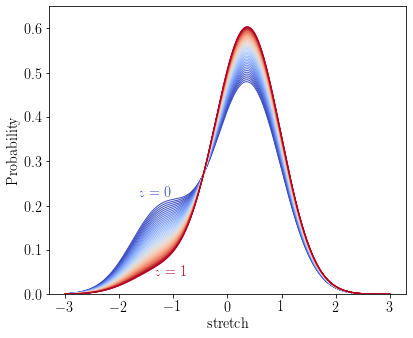

In [4]:
gen = stretchevol.generic()
gen.set_model('Evol3G2M2S')
baseTOT = gen.fit(df_nc.loc[df_nc['survey'] != 'LOWZ'])

fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

dgmap = plt.cm.get_cmap('coolwarm')

x_lin = np.linspace(-3, 3, 1000)
z_lin = np.linspace(0, 1, 50)

z_m, z_p = np.percentile(z_lin, [5, 95])

for z in z_lin:
    pdfmodel_mid = baseTOT.plot_a(z, x_lin)
    ax.plot(x_lin,
            pdfmodel_mid,
            color=dgmap((z-z_m)/(z_p-z_m)),
            lw=1)
    
ax.text(-1.35, 0.23, r'$z=0$', color=dgmap(0),
        fontsize='x-large', ha='center', va='center')

ax.text(-1.35, 0.05, r'$z=1$', color=dgmap(0.99),
        fontsize='x-large', ha='left', va='center')

ax.set_ylim(0, 0.65)

ax.set_xlabel('stretch', fontsize='x-large')
ax.set_ylabel('Probability', fontsize='x-large')
ax.tick_params(labelsize='x-large')

# fig.savefig('../../../Images/pdf/model_base_pdf-0-1.pdf', bbox_inches='tight')
# fig.savefig('../../../Images/png/model_base_pdf-0-1.png', bbox_inches='tight', dpi=600)

In [5]:
# gen = stretchevol.generic()
# gen.set_model('Evol3G2M2S')
# baseTOT = gen.fit(df_nc)
baseTOT = stretchevol.Evol3G2M2S(df_nc)
baseTOT.minimize()
x_lin = np.linspace(-3, 3, 1000)
pdfmodel_mid = baseTOT.plot_a(0.15, x_lin)

In [5]:
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/basemodel-lin.txt', x_lin)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/basemodel-val.txt', pdfmodel_mid)

### Plot basic z, x, c histograms of surveys

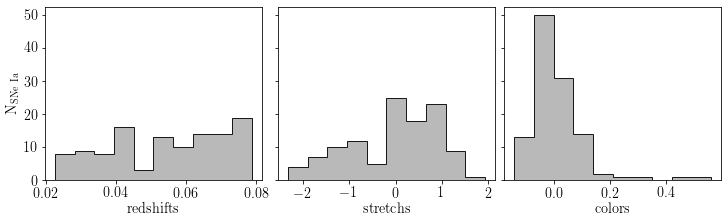

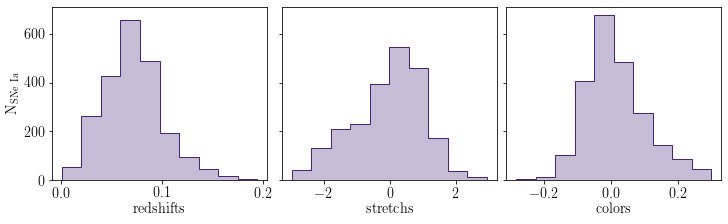

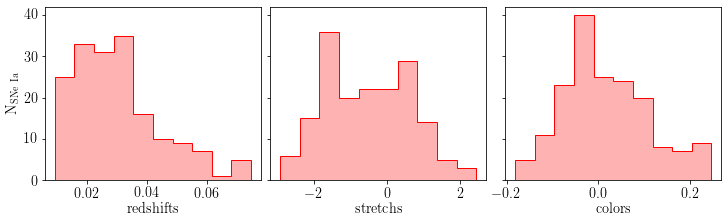

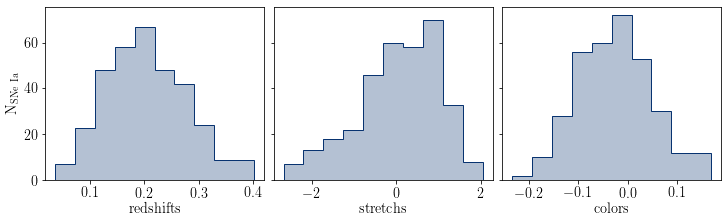

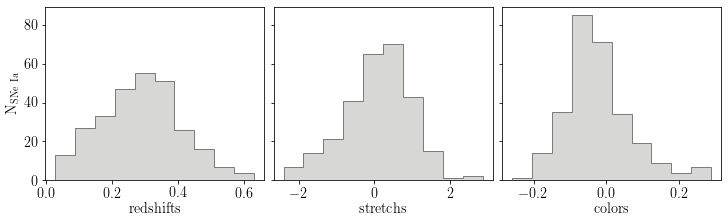

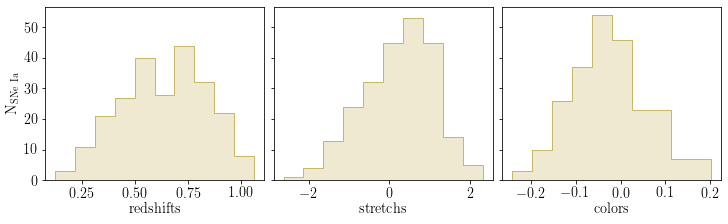

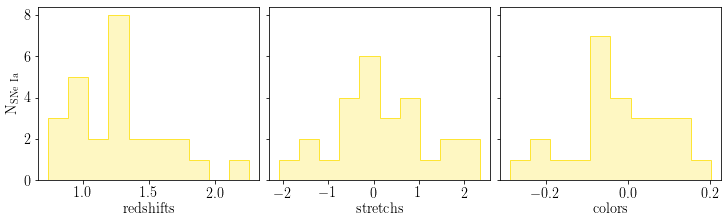

In [75]:
for survey in surveys:
    fig = plt.figure(figsize=[10, 3], constrained_layout=True)
    gs = fig.add_gridspec(1, 3)
    axd = gs.subplots(sharey='row')
    for i, type in enumerate(['redshifts', 'stretchs', 'colors']):
        df_used = df_full.loc[df_full['survey'] == survey] 
        axd[i].hist(df_used[type], color=colors[survey], alpha=.3)
        axd[i].hist(df_used[type], color=colors[survey], histtype='step')
        axd[i].set_xlabel(f'{type}')
        if i == 0:
            axd[i].set_ylabel(r'N$_{\rm SNe~Ia}$')
    fig.savefig(f'../../../Images/pdf/hist_{survey}_zxc.pdf', bbox_inches='tight')

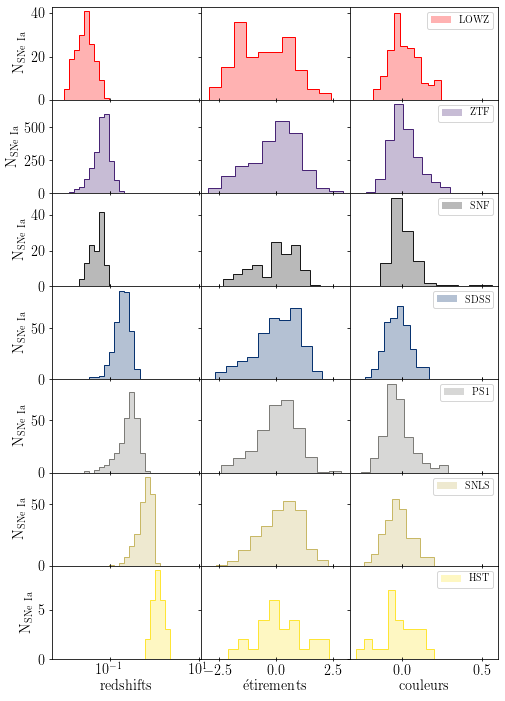

In [ ]:
fig = plt.figure(figsize=[8, 12], constrained_layout=False)
gs = fig.add_gridspec(7, 3, wspace=0.00, hspace=0)
axd = gs.subplots(sharey='row', sharex='col')
logbins = 10**np.linspace(np.log10(np.min(df_nc.redshifts)),
                          np.log10(np.max(df_nc.redshifts)), 30)
for i, survey in enumerate(['LOWZ', 'ZTF']+surveysnl):#[:2]+surveys[3:]):
    for k, param in enumerate(zip(['redshifts', 'stretchs', 'colors'],
                                        ['redshifts', 'étirements', 'couleurs'])):
        totype = param[0]
        toprint = param[1]
        df_used = df_full.loc[df_full['survey'] == survey] 
        if k == 0:
            axd[i][k].set_xscale('log')
            axd[i][k].set_xlim(left=0.005)
            axd[i][k].set_ylabel(r'N$_{\rm SNe~Ia}$')
            axd[i][k].hist(df_used[totype], color=colors[survey],
                           bins=logbins, density=False,
                           alpha=.3, label=survey)
            axd[i][k].hist(df_used[totype], color=colors[survey],
                           bins=logbins, density=False,
                           histtotype='step')
        else:
            axd[i][k].hist(df_used[totype], color=colors[survey],
                           density=False,
                           alpha=.3, label=survey)
            axd[i][k].hist(df_used[totype], color=colors[survey],
                           density=False,
                           histtotype='step')
        if k == 2:
            axd[i][k].legend()
        if i > 0:
            axd[i][k].tick_params(axis='x', top=True, direction='inout')
        if i == 6:
            axd[i][k].set_xlabel(f'{toprint}')
fig.savefig(f'../../../Images/pdf/hist_all_zxc.pdf', bbox_inches='tight')

### Plot hostlib and fitres data to check NN not simulating 2 lowz peaks

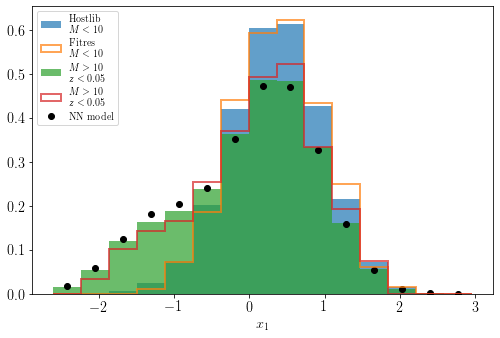

In [253]:
hostlib = pd.read_csv('/home/nicolas/Work/devpython/variaIa/Data/hostlibs/2G2M4S_SED_ALL/NN_lowz.HOSTLIB',
                      delim_whitespace=True)
fitres = tools.Checker.read('/home/nicolas/Work/devpython/variaIa/Data/sims/' +
                            'NN_COMBINE_FULL-7DMAJ/6_BIASCOR/' +
                            'ALL_BIASCOR_NN_NN/output/OUTPUT_BBCFIT/FITOPT000_MUOPT002.FITRES')
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop = {'density': True, 'alpha':.7}
Mcut = 10
zcut = 0.05
bins = 15

lm_hostlib = hostlib.loc[hostlib['LOGMASS'] < Mcut]
hm_hostlib = hostlib.loc[hostlib['LOGMASS'] > Mcut]
hm_lz_hostlib = hostlib.loc[(hostlib['LOGMASS'] > Mcut) &
                            (hostlib['ZTRUE'] < zcut)]
lm_fitres = fitres.loc[fitres['HOST_LOGMASS'] < Mcut]
hm_fitres = fitres.loc[fitres['HOST_LOGMASS'] > Mcut]
hm_lz_fitres = fitres.loc[(fitres['HOST_LOGMASS'] > Mcut) &
                           (fitres['zCMB'] < zcut)]

_, rng, _ = ax.hist(lm_hostlib['X1'],
                  label=f'Hostlib\n$M < {Mcut}$',
                  bins=bins,
                  **prop)
ax.hist(lm_fitres['x1'],
       label=f'Fitres\n$M < {Mcut}$',
        bins=rng,
        histtype='step', lw=2,
       **prop)
ax.hist(hm_lz_hostlib['X1'],
        label=f'$M > {Mcut}$\n$ z < {zcut}$',
        bins=rng,
        **prop)
ax.hist(hm_lz_fitres['x1'],
       label=f'$M > {Mcut}$\n$ z < {zcut}$',
        bins=rng,
        histtype='step', lw=2,
       **prop)

cbins = (rng[:-1] + rng[1:])/2

pdfbase_bins = baseTOT.likelihood_tot(baseTOT.delta(np.mean(hostlib['ZTRUE'])),
                                      cbins, 0,
                                      baseTOT.param['aa'],
                                      baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                      baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        
ax.scatter(cbins, pdfbase_bins, color='k', label='NN model')

ax.set_xlabel(r'$x_1$')
#ax.tick_params(labelsize='x-large')
ax.legend(loc='upper left')

fig.savefig('/home/nicolas/Work/devpython/variaIa/Images/pdf/snana_diagnostic_x1pM.pdf',
           bbox_inches='tight')

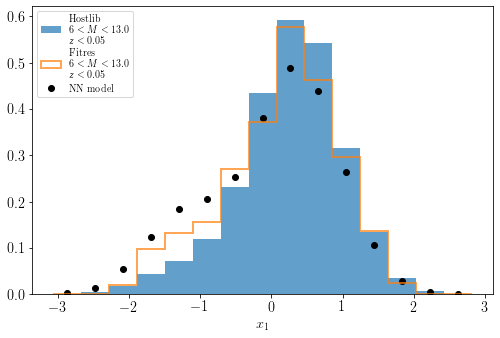

In [258]:
hostlib = pd.read_csv('/home/nicolas/Work/devpython/variaIa/Data/hostlibs/2G2M4S_SED_ALL/NN_lowz.HOSTLIB',
                      delim_whitespace=True)
fitres = tools.Checker.read('/home/nicolas/Work/devpython/variaIa/Data/sims/' +
                            'NN_COMBINE_FULL-7DMAJ/6_BIASCOR/' +
                            'ALL_BIASCOR_NN_NN/output/OUTPUT_BBCFIT/FITOPT000_MUOPT002.FITRES')
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop = {'density': True, 'alpha':.7}
Mcut_l = 6
Mcut_r = 13.
zcut = 0.05
bins = 15

mm_hostlib = hostlib.loc[(hostlib['LOGMASS'] > Mcut_l) &
                         (hostlib['LOGMASS'] < Mcut_r) &
                         (hostlib['ZTRUE'] < zcut)]
mm_fitres = fitres.loc[(fitres['HOST_LOGMASS'] > Mcut_l) &
                       (fitres['HOST_LOGMASS'] < Mcut_r) &
                       (fitres['zCMB'] < zcut)]

_, rng, _ = ax.hist(mm_hostlib['X1'],
                  label=f'Hostlib\n${Mcut_l} < M < {Mcut_r}$\n$ z < {zcut}$',
                  bins=bins,
                  **prop)
ax.hist(mm_fitres['x1'],
                  label=f'Fitres\n${Mcut_l} < M < {Mcut_r}$\n$ z < {zcut}$',
        bins=rng,
        histtype='step', lw=2,
       **prop)

cbins = (rng[:-1] + rng[1:])/2

pdfbase_bins = baseTOT.likelihood_tot(baseTOT.delta(np.mean(hostlib['ZTRUE'])),
                                      cbins, 0,
                                      baseTOT.param['aa'],
                                      baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                      baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        
ax.scatter(cbins, pdfbase_bins, color='k', label='NN model')

ax.set_xlabel(r'$x_1$')
ax.legend(loc='upper left')

fig.savefig('/home/nicolas/Work/devpython/variaIa/Images/pdf/snana_diagnostic_x1pMm.pdf',
           bbox_inches='tight')

#### Same for SHIFT

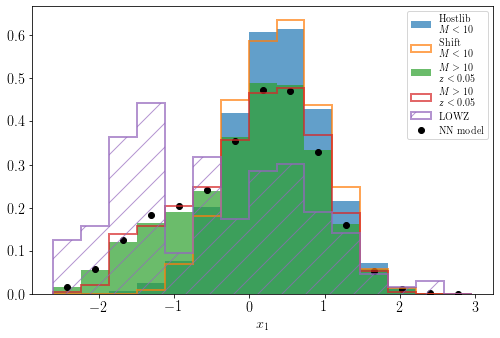

In [265]:
hostlib = pd.read_csv('/home/nicolas/Work/devpython/variaIa/Data/hostlibs/2G2M4S_SED_ALL/NN_lowz.HOSTLIB',
                      delim_whitespace=True)
fitres = tools.Checker.read('/home/nicolas/Work/devpython/variaIa/Data/sims/' +
                            'NN_COMBINE_FULL-7DMAJSHIFT/6_BIASCOR/' +
                            'ALL_BIASCOR_NN_NN/output/OUTPUT_BBCFIT/FITOPT000_MUOPT002.FITRES')
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop = {'density': True, 'alpha':.7}
Mcut = 10
zcut = 0.05
bins = 15

lm_hostlib = hostlib.loc[hostlib['LOGMASS'] < Mcut]
hm_hostlib = hostlib.loc[hostlib['LOGMASS'] > Mcut]
hm_lz_hostlib = hostlib.loc[(hostlib['LOGMASS'] > Mcut) &
                            (hostlib['ZTRUE'] < zcut)]
lm_fitres = fitres.loc[fitres['HOST_LOGMASS'] < Mcut]
hm_fitres = fitres.loc[fitres['HOST_LOGMASS'] > Mcut]
hm_lz_fitres = fitres.loc[(fitres['HOST_LOGMASS'] > Mcut) &
                           (fitres['zCMB'] < zcut)]

_, rng, _ = ax.hist(lm_hostlib['X1'],
                  label=f'Hostlib\n$M < {Mcut}$',
                  bins=bins,
                  **prop)
ax.hist(lm_fitres['x1'],
       label=f'Shift\n$M < {Mcut}$',
        bins=rng,
        histtype='step', lw=2,
       **prop)
ax.hist(hm_lz_hostlib['X1'],
        label=f'$M > {Mcut}$\n$z < {zcut}$',
        bins=rng,
        **prop)
ax.hist(hm_lz_fitres['x1'],
       label=f'$M > {Mcut}$\n$z < {zcut}$',
        bins=rng,
        histtype='step', lw=2,
       **prop)
df_lowz = df_nc.loc[df_nc['survey'] == 'LOWZ']
ax.hist(df_lowz['stretchs'],
        label='LOWZ',
        bins=rng,
        histtype='step', hatch='/', lw=2,
        **prop)
df_snf = df_nc.loc[df_nc['survey'] == 'SNF']
# ax.hist(df_snf.loc[(df_snf['hostmass'] $ <$ Mcut) & (df_snf['redshifts'] $ <$ zcut)]['stretchs'],
#         label=f'SNF\nM $ <$ {Mcut}\n z $ <$ {zcut}',
#         bins=rng,
#         histtype='step', hatch='\\', lw=2,
#         color='C5',
#         **prop)

cbins = (rng[:-1] + rng[1:])/2

pdfbase_bins = baseTOT.likelihood_tot(baseTOT.delta(np.mean(hostlib['ZTRUE'])),
                                      cbins, 0,
                                      baseTOT.param['aa'],
                                      baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                      baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        
ax.scatter(cbins, pdfbase_bins, color='k', label='NN model')

ax.set_xlabel(r'$x_1$', fontsize='x-large')
ax.tick_params(labelsize='x-large')
ax.legend(loc='upper right')

fig.savefig('/home/nicolas/Work/devpython/variaIa/Images/pdf/snana_diagnostic_x1pM_shift.pdf',
           bbox_inches='tight')

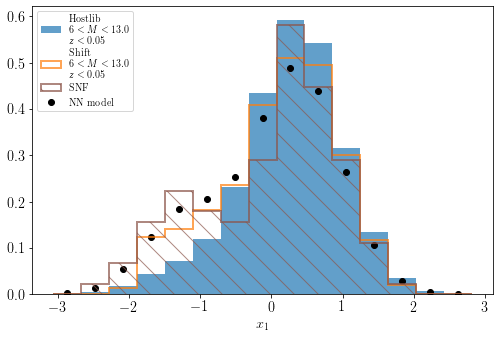

In [268]:
hostlib = pd.read_csv('/home/nicolas/Work/devpython/variaIa/Data/hostlibs/2G2M4S_SED_ALL/NN_lowz.HOSTLIB',
                      delim_whitespace=True)
fitres = tools.Checker.read('/home/nicolas/Work/devpython/variaIa/Data/sims/' +
                            'NN_COMBINE_FULL-7DMAJSHIFT/6_BIASCOR/' +
                            'ALL_BIASCOR_NN_NN/output/OUTPUT_BBCFIT/FITOPT000_MUOPT002.FITRES')
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

prop = {'density': True, 'alpha':.7}
Mcut_l = 6
Mcut_r = 13.
zcut = 0.05
bins = 15

mm_hostlib = hostlib.loc[(hostlib['LOGMASS'] > Mcut_l) &
                         (hostlib['LOGMASS'] < Mcut_r) &
                         (hostlib['ZTRUE'] < zcut)]
mm_fitres = fitres.loc[(fitres['HOST_LOGMASS'] > Mcut_l) &
                       (fitres['HOST_LOGMASS'] < Mcut_r) &
                       (fitres['zCMB'] < zcut)]

_, rng, _ = ax.hist(mm_hostlib['X1'],
                  label=f'Hostlib\n${Mcut_l} < M < {Mcut_r}$\n$ z < {zcut}$',
                  bins=bins,
                  **prop)
ax.hist(mm_fitres['x1'],
                  label=f'Shift\n${Mcut_l} < M < {Mcut_r}$\n$ z < {zcut}$',
        bins=rng,
        histtype='step', lw=2,
       **prop)
ax.hist(df_nc.loc[df_nc['survey'] == 'SNF']['stretchs'],
        label='SNF',
        bins=rng,
        histtype='step', hatch='\\', lw=2,
        color='C5',
        **prop)

cbins = (rng[:-1] + rng[1:])/2

pdfbase_bins = baseTOT.likelihood_tot(baseTOT.delta(np.mean(hostlib['ZTRUE'])),
                                      cbins, 0,
                                      baseTOT.param['aa'],
                                      baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                      baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
        
ax.scatter(cbins, pdfbase_bins, color='k', label='NN model')

ax.set_xlabel(r'$x_1$', fontsize='x-large')
ax.legend(loc='upper left')

fig.savefig('/home/nicolas/Work/devpython/variaIa/Images/pdf/snana_diagnostic_x1pMm_shift.pdf',
           bbox_inches='tight')

### Plot cumulative fraction of young/old per bins of mass

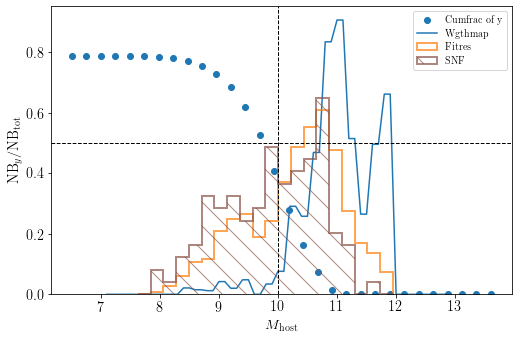

In [262]:
hostlib = pd.read_csv('/home/nicolas/Work/devpython/variaIa/Data/hostlibs/2G2M2S_SNF_supp/NR_lowz.HOSTLIB',
                      delim_whitespace=True).drop('VARNAMES:', axis=1)
wgthmap = pd.read_csv('/home/nicolas/Work/devpython/variaIa/Data/wgthmaps/LOWZ.WGT',
                      delim_whitespace=True)

hostlib['MBIN'] = pd.cut(hostlib['LOGMASS'], 30)
list_bins = np.unique(hostlib['MBIN'])
rranges = [list_bins[i].right for i in range(len(list_bins))]
yfrac = []

for rrange in rranges:
    temp_lib = hostlib.loc[hostlib['LOGMASS'] > rrange]
    num_o = temp_lib.loc[temp_lib['LOGsSFR'] == 0]
    # print(len(num_o))
    num_y = temp_lib.loc[temp_lib['LOGsSFR'] == 1]
    yfrac.append(len(num_y)/(len(num_o)+len(num_y)))

fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax.scatter(rranges, yfrac, label='Cumfrac of y')
wgth_plt = wgthmap.loc[(wgthmap['LOGMASS'] > 7) & (wgthmap['LOGMASS'] < 13)]
ax.plot(wgth_plt.LOGMASS, wgth_plt.WGT, label='Wgthmap')

prop = {'density': True, 'alpha':.7}

_, rng, _ = ax.hist(fitres['HOST_LOGMASS'],
                    label=f'Fitres',
                     bins=20,
                     histtype='step', lw=2,
                    **prop)
# ax.hist(df['hostmass'],
#         label='LOWZ',
#         bins=rng,
#         histtype='step', hatch='/', lw=2,
#         color='C4',
#         **prop)
ax.hist(df_nc.loc[df_nc['survey'] == 'SNF']['hostmass'],
        label='SNF',
        bins=rng,
        histtype='step', hatch='\\', lw=2,
        color='C5',
        **prop)

ax.axhline(0.5, color='k', lw=1, ls='--')
ax.axhline(0, color='k', lw=1, zorder=0)
ax.axvline(10.0, color='k', lw=1, ls='--')

ax.set_xlabel(r'$M_{\rm host}$', fontsize='x-large')
ax.set_ylabel(r'$\mathrm{NB}_y/\mathrm{NB}_{\rm tot}$', fontsize='x-large')

ax.tick_params(labelsize='x-large')

ax.legend()

fig.savefig('/home/nicolas/Work/devpython/variaIa/Images/pdf/snana_diagnostic_fypM_SNF_supp.pdf',
           bbox_inches='tight')

### Same, *not* cumulative

#### Make df for sigmoids

In [4]:
sed = pd.read_csv('../../../Data/mass/SNFactory_SEDfit_Masses.txt')
sed = sed.loc[sed['name'].str.contains( 'SNF|LSQ|PTF', na=False, regex=True)]
sed = sed.rename(columns={'mass': 'hostmass', 'z': 'redshifts'})
sed['hostmass_err'] = np.sqrt((sed['mass_uppererr'].values**2 +
                               sed['mass_lowerr'].values**2)/2)
df_sed_snf = df_nc.loc[df_nc['survey'] == 'SNF'].copy()
df_sed_snf['hostmass'] = sed['hostmass'].values
df_sed_snf['hostmass_err'] = sed['hostmass_err'].values
df_sed_snf = df_sed_snf.loc[~np.isnan(df_sed_snf['hostmass'])]
df_fit = pd.concat([df_sed_snf,
                    df_nc[(df_nc['survey'] != 'SNF') &
                          (df_nc['survey'] != 'LOWZ')]])
df_fit = df_fit[df_fit['hostmass'] > 7]
df_snf = df_nc.loc[df_nc['survey'] == 'SNF']

#### Interactive plot

In [7]:
bins_int = ipw.IntSlider(min=5, max=30,
                         value=30, continuous_update=False)
type_select = ipw.Dropdown(options=['mass', 'stretch', 'redshift'],
                           value='mass')
fitr_select = ipw.Dropdown(options=['7DMAJ', '7DMAJSHIFT', 'SNF',
                                    'SEDSNF', 'SNFSUPP', 'SNFSHIFT'],
                           value='SNF')
kind_select = ipw.Dropdown(options=['NN', 'NR'],
                           value='NR')
show_select = ipw.Checkbox(value=True)

find_host = {'7DMAJ': '2G2M4S_SED_ALL',
             '7DMAJSHIFT': '2G2M4S_SED_ALL',
             'SNF': '2G2M2S_SNF',
             'SNFSHIFT': '2G2M2S_SNF',
             'SEDSNF': '2G2M2S_SED_SNF',
             'SNFSUPP': '2G2M2S_SNF_supp'}
find_data = {'7DMAJ': df_fit,
             '7DMAJSHIFT': df_fit,
             'SNF': df_snf,
             'SNFSHIFT': df_snf,
             'SEDSNF': df_sed_snf,
             'SNFSUPP': df_snf}

def hist_int(bins, type, sim, kind, showmod):
    fitres = tools.Checker.read('/home/nicolas/Work/devpython/variaIa/Data/sims/' +
                                f'NN_COMBINE_FULL-{sim}/6_BIASCOR/' +
                                f'ALL_BIASCOR_{kind}_{kind}/output/OUTPUT_BBCFIT/' + 
                                'FITOPT000_MUOPT002.FITRES')
    fig = plt.figure(figsize=[16, 8], constrained_layout=True)
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    axd = [ax1, ax2, ax3, ax4]
    
    if '7D' in sim:
        SFRkey = 'sSFR'
    else:
        SFRkey = 'HOST_LOGsSFR'
    
    for i, survey in enumerate(surveys[1:-1]):
        if i == 0:
            hostlib = pd.read_csv(f'../../../Data/hostlibs/{find_host[sim]}/NR_lowz.HOSTLIB',
                      delim_whitespace=True, skiprows=11).drop('VARNAMES:', axis=1)
        else:
            hostlib = pd.read_csv(f'../../../Data/hostlibs/{find_host[sim]}/NR_highz.HOSTLIB',
                      delim_whitespace=True, skiprows=11).drop('VARNAMES:', axis=1)
        fitres_temp = fitres.loc[fitres['IDSURVEY'].isin(tools.Checker.find_id[survey])].copy()
        if 'mass' in type:
            hostlib['MBIN'] = pd.cut(hostlib['LOGMASS'], bins)
            list_bins = np.unique(hostlib['MBIN'])
            cbin_hl = [(binn.left + binn.right)/2 for binn in list_bins]
            yfrac_hl = []
            
            for binn in list_bins:
                temp_lib = hostlib.loc[(hostlib['LOGMASS'] > binn.left) &
                                       (hostlib['LOGMASS'] <= binn.right)]
                num_o = temp_lib.loc[temp_lib['LOGsSFR'] == 0]
                # print(len(num_o))
                num_y = temp_lib.loc[temp_lib['LOGsSFR'] == 1]
                yfrac_hl.append(len(num_y)/(len(num_o)+len(num_y)))
                
            fitres_temp['MBIN'] = pd.cut(fitres_temp['HOST_LOGMASS'], bins)
            list_bins = np.unique(fitres_temp['MBIN'])
            cbin_fr = [(binn.left + binn.right)/2 for binn in list_bins]
            yfrac_fr = []
            
            for binn in list_bins:
                temp_lib = fitres_temp.loc[(fitres_temp['HOST_LOGMASS'] > binn.left) &
                                       (fitres_temp['HOST_LOGMASS'] <= binn.right)]
                num_o = temp_lib.loc[temp_lib['HOST_LOGsSFR'] == 0]
                # print(len(num_o))
                num_y = temp_lib.loc[temp_lib['HOST_LOGsSFR'] == 1]
                yfrac_fr.append(len(num_y)/(len(num_o)+len(num_y)))
            
            axd[i].scatter(cbin_hl, yfrac_hl, color='k', label='HOSTLIB')
            axd[i].scatter(cbin_fr, yfrac_fr, color=colors[survey], label='FITRES')
    
            if showmod:
                gen = massevol.generic()
                namemod = find_host[sim].split('_')[0]
                gen.set_model(f'Evol{namemod}')
                mod = gen.fit(find_data[sim])
                Mlin = np.linspace(mod.floor, mod.ceil, 3000) 
                l_y = mod.plot_y(Mlin) 
                l_o = mod.plot_o(Mlin) 
                frac = massevol.Evol2G2M2S.delta(np.mean(fitres_temp['zCMB']))
                # frac = massevol.Evol2G2M2S.delta(np.mean(hostlib['ZTRUE']))
                l_t = frac*l_y + (1-frac)*l_o
                #yo = l_y/(l_y+l_o) 
                yo = frac*l_y/l_t 
                axd[i].plot(Mlin, yo, color='C1', label='Model')
            
            axd[i].axvline(10.0, color='k', lw=1, ls='--')

            if i > 1:
                axd[i].set_xlabel(r'$M_{\rm host}$', fontsize='x-large')

        if 'stretch' in type:
            hostlib['xBIN'] = pd.cut(hostlib['X1'], bins)
            list_bins = np.unique(hostlib['xBIN'])
            cbin_hl = [(binn.left + binn.right)/2 for binn in list_bins]
            yfrac_hl = []
            
            for binn in list_bins:
                temp_lib = hostlib.loc[(hostlib['X1'] > binn.left) &
                                       (hostlib['X1'] <= binn.right)]
                num_o = temp_lib.loc[temp_lib['LOGsSFR'] == 0]
                # print(len(num_o))
                num_y = temp_lib.loc[temp_lib['LOGsSFR'] == 1]
                yfrac_hl.append(len(num_y)/(len(num_o)+len(num_y)))
                
            fitres_temp['xBIN'] = pd.cut(fitres_temp['x1'], bins)
            list_bins = np.unique(fitres_temp['xBIN'])
            cbin_fr = [(binn.left + binn.right)/2 for binn in list_bins]
            yfrac_fr = []
            
            for binn in list_bins:
                temp_lib = fitres_temp.loc[(fitres_temp['x1'] > binn.left) &
                                       (fitres_temp['x1'] <= binn.right)]
                num_o = temp_lib.loc[temp_lib['HOST_LOGsSFR'] == 0]
                # print(len(num_o))
                num_y = temp_lib.loc[temp_lib['HOST_LOGsSFR'] == 1]
                yfrac_fr.append(len(num_y)/(len(num_o)+len(num_y)))
            
            axd[i].scatter(cbin_hl, yfrac_hl, color='k', label='HOSTLIB')
            axd[i].scatter(cbin_fr, yfrac_fr, color=colors[survey], label='FITRES')
            
            if showmod:
                gen = stretchevol.generic()
                gen.set_model(f'Evol3G2M2S')
                mod = gen.fit(df_nc.loc[df_nc['survey'] != 'LOWZ'])
                xlin = np.linspace(mod.floor, mod.ceil, 3000) 
                l_y = mod.plot_y(xlin) 
                l_o = mod.plot_o(xlin) 
                frac = massevol.Evol2G2M2S.delta(np.mean(fitres_temp['zCMB']))
                # frac = massevol.Evol2G2M2S.delta(np.mean(hostlib['ZTRUE']))
                l_t = frac*l_y + (1-frac)*l_o
                #yo = l_y/(l_y+l_o) 
                yo = frac*l_y/l_t 
                axd[i].plot(xlin, yo, color='C1', label='Model')
            
            if i > 1:
                axd[i].set_xlabel(r'$x_1$', fontsize=20)
    
        if 'redshift' in type:
            hostlib['zBIN'] = pd.cut(hostlib['ZTRUE'], bins)
            list_bins = np.unique(hostlib['zBIN'])
            cbin_hl = [(binn.left + binn.right)/2 for binn in list_bins]
            yfrac_hl = []
            
            for binn in list_bins:
                temp_lib = hostlib.loc[(hostlib['ZTRUE'] > binn.left) &
                                       (hostlib['ZTRUE'] <= binn.right)]
                num_o = temp_lib.loc[temp_lib['LOGsSFR'] == 0]
                # print(len(num_o))
                num_y = temp_lib.loc[temp_lib['LOGsSFR'] == 1]
                yfrac_hl.append(len(num_y)/(len(num_o)+len(num_y)))
                
            fitres_temp['zBIN'] = pd.cut(fitres_temp['zCMB'], bins)
            list_bins = np.unique(fitres_temp['zBIN'])
            cbin_fr = [(binn.left + binn.right)/2 for binn in list_bins]
            yfrac_fr = []
            
            for binn in list_bins:
                temp_lib = fitres_temp.loc[(fitres_temp['zCMB'] > binn.left) &
                                       (fitres_temp['zCMB'] <= binn.right)]
                num_o = temp_lib.loc[temp_lib['HOST_LOGsSFR'] == 0]
                # print(len(num_o))
                num_y = temp_lib.loc[temp_lib['HOST_LOGsSFR'] == 1]
                yfrac_fr.append(len(num_y)/(len(num_o)+len(num_y)))
            
            axd[i].scatter(cbin_hl, yfrac_hl, color='k', label='HOSTLIB')
            axd[i].scatter(cbin_fr, yfrac_fr, color=colors[survey], label='FITRES')
            
            if showmod:
                zlin = np.linspace(0, 2, 1000)
                axd[i].plot(zlin,
                            stretchevol.Evol2G2M2S.delta(zlin),
                            color='C1',
                            label='$\delta(z)$')
            
            if i > 1:
                axd[i].set_xlabel(r'$z$', fontsize=20)
                
        axd[i].axhline(0.5, color='k', lw=1, ls='--')
        axd[i].axhline(0, color='k', lw=1, zorder=0)
        if i < 2:
            axd[i].set_xticks([])
        if not bool(i%2):
            axd[i].set_ylabel(r'$\mathrm{N}_y/\mathrm{N}_{\rm tot}$', fontsize='x-large')
        if bool(i%2):
            axd[i].set_yticks([])

        axd[i].tick_params(labelsize='x-large')
        axd[i].legend()

        axd[i].set_title(f'{survey}')
        fig.suptitle(f'{kind} {sim}', fontsize='x-large')
        
        plt.close()
        if 'stretch' in type:
            path = 'x1'
        if 'mass' in type:
            path = 'M'
        if 'redshift' in type:
            path = 'z'
        if showmod:
            show = '_model'
        else:
            show = ''
        fig.savefig(f'../../../Images/pdf/snana_diagnostic_fyp{path}-{kind}{sim}{show}.pdf',
                    bbox_inches='tight')

hist_inter = ipw.interactive(hist_int, bins=bins_int,
                             type=type_select, sim=fitr_select,
                             kind=kind_select, showmod=show_select)
display(hist_inter)

interactive(children=(IntSlider(value=30, continuous_update=False, description='bins', max=30, min=5), Dropdow…

### Plot WGTMAPS

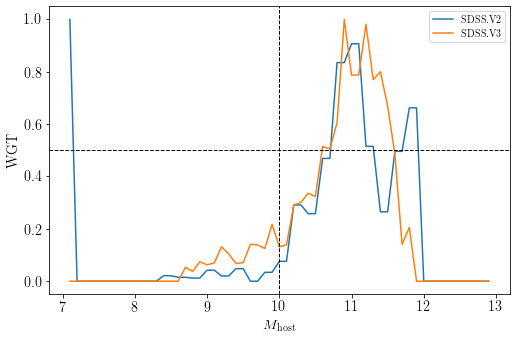

In [55]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
wgthmap0 = pd.read_csv('/home/nicolas/Work/devpython/variaIa/Data/wgthmaps/SDSS.WGT',
                      delim_whitespace=True)
wgthmap1 = pd.read_csv('/home/nicolas/Work/devpython/variaIa/Data/wgthmaps/SDSS.v3.WGT',
                      delim_whitespace=True)

wgth_plt0 = wgthmap0.loc[(wgthmap0['LOGMASS'] > 7) & (wgthmap0['LOGMASS'] < 13)]
ax.plot(wgth_plt0.LOGMASS, wgth_plt0.WGT, label='SDSS.V2')
wgth_plt1 = wgthmap1.loc[(wgthmap1['LOGMASS'] > 7) & (wgthmap1['LOGMASS'] < 13)]
ax.plot(wgth_plt1.LOGMASS, wgth_plt1.WGT, label='SDSS.V3')

# ax.axhline(0, color='k', lw=1, ls='-')
ax.axhline(0.5, color='k', lw=1, ls='--')
ax.axvline(10.0, color='k', lw=1, ls='--')

ax.set_xlabel(r'$M_{\rm host}$', fontsize='x-large')
ax.set_ylabel('WGT', fontsize='x-large')

ax.tick_params(labelsize='x-large')

ax.legend()

fig.savefig('../../../Images/pdf/wgtmap_comp-SDSS2v3.pdf', bbox_inches='tight')

## Draw $x_1$, $M$ of all Pantheon vs NN biascor data

#### Plot

In [90]:
bins_int = ipw.IntSlider(min=5, max=30,
                         value=12, continuous_update=False)
type_select = ipw.Dropdown(options=['mass', 'stretch', 'redshift'],
                           value='stretch')
fitr_select = ipw.Dropdown(options=['7DMAJ', '7DMAJSHIFT', 'SNF',
                                    'SEDSNF', 'SNFSUPP', 'SNFSHIFT'],
                           value='SNFSHIFT')
kind_select = ipw.Dropdown(options=['SK', 'BP', 'NN', 'NR'],
                           value='NR')
step_select = ipw.Dropdown(options=['MERGE', 'BIASCOR'],
                           value='BIASCOR')
show_select = ipw.Checkbox(value=True)
subl_select = ipw.Checkbox()

find_host = {'7DMAJ': '2G2M4S_SED_ALL',
             '7DMAJSHIFT': '2G2M4S_SED_ALL',
             'SNF': '2G2M2S_SNF',
             'SNFSHIFT': '2G2M2S_SNF',
             'SEDSNF': '2G2M2S_SED_SNF',
             'SNFSUPP': '2G2M2S_SNF_supp'}
find_data = {'7DMAJ': df_fit,
             '7DMAJSHIFT': df_fit,
             'SNF': df_snf,
             'SNFSHIFT': df_snf,
             'SEDSNF': df_sed_snf,
             'SNFSUPP': df_snf}

def hist_int(bins, type, sim, kind, step, showmod, sublowz):
    global fitres
    if 'MERGE' in step:
        fit_dir = glob.glob('../../../Data/sims/' +
                            f'NN_COMBINE_FULL-{sim}/5_MERGE/' +
                            f'*DATA*{kind}/*/*/*')
        fitres = pd.concat([tools.Checker.read(fit) for fit in fit_dir])
    if 'BIASCOR' in step:
        fitres = tools.Checker.read('/home/nicolas/Work/devpython/variaIa/Data/sims/' +
                                    f'NN_COMBINE_FULL-{sim}/6_BIASCOR/' +
                                    f'ALL_BIASCOR_{kind}_{kind}/output/OUTPUT_BBCFIT/' +
                                    'FITOPT000_MUOPT002.FITRES')
    fig = plt.figure(figsize=[16, 8], constrained_layout=True)
    gs = fig.add_gridspec(2, 4)
    ax0 = fig.add_subplot(gs[:, :2])
    ax1 = fig.add_subplot(gs[0, 2])
    ax2 = fig.add_subplot(gs[0, 3])
    ax3 = fig.add_subplot(gs[1, 2])
    ax4 = fig.add_subplot(gs[1, 3])
    axd = [ax1, ax2, ax3, ax4]
    
    prop = {'density': True}
    
    df_type = tools.Checker.find_name[type][1]
    fitres_type = tools.Checker.find_name[type][0]
    if 'SHIFT' in sim:
        fitlab = 'Shift'
    else:
        fitlab = 'Fitres'
    
    # if 'mass' in type:
    #     df_used = df_full.loc[~df_full['survey'].isin(['SNF', 'HST'])]
    #     df_used = df_used.loc[df_used['hostmass'] > 7]
    # else:
    df_used = df_full.loc[~df_full['survey'].isin(['SNF', 'HST'])]
    df_used = df_used.loc[df_used['hostmass'] > 7]
    _, rng, _ = ax0.hist(df_used[df_type], bins=bins,
                         **prop, alpha=0.3,
                         label='Pantheon')
    ax0.hist(fitres[fitres_type], bins=rng,
             **prop, histtype='step', lw=2,
             label=fitlab)
    cbins = (rng[:-1] + rng[1:])/2

    if 'stretch' in type:
        ax0.set_xlim([-3, 3])
        if showmod:
            gen = stretchevol.generic()
            gen.set_model('Evol3G2M2S')
            baseTOT = gen.fit(df_nc.loc[df_nc['survey'] != 'LOWZ'])
            pdfbase_bins = baseTOT.plot_a(cbins, z=np.mean(df_used['redshifts']))
                
            ax0.scatter(cbins, pdfbase_bins, color='k', label='NN model') 
        ax0.set_xlabel(r'$x_1$', fontsize=20)

    if 'mass' in type:
        if showmod:
            gen = massevol.generic()
            namemod = find_host[sim].split('_')[0]
            gen.set_model(f'Evol{namemod}')
            mod = gen.fit(find_data[sim])
            pdfbase_bins = mod.plot_a(cbins, z=np.mean(df_used['redshifts']))
                
            ax0.scatter(cbins, pdfbase_bins, color='k', label='NN model') 
        #ax0.set_xlim([7, 12])
        ax0.set_xlabel(r'$M$', fontsize=20)
    
    if 'redshift' in type:
        ax0.set_xlim([0.99*np.min(df_used.redshifts), 1.1*np.max(df_used.redshifts)])
        ax0.set_xlabel(r'$z$', fontsize=20)

    ax0.set_ylabel('Prob', fontsize=20)
    ax0.tick_params(labelsize=20)
    
    ax0.legend(loc='upper left', fontsize=20)
    
    for i, survey in enumerate(np.unique(df_used['survey'])):
        prop = {'density': True, 'color': colors[survey]}
        if sublowz:
            panth_df = tools.Checker.read('../../../Data/sne/ancillary_g10_n.FITRES')
            lowz_df = panth_df.loc[panth_df['IDSURVEY'].isin(tools.Checker.find_id['LOWZ'])]
            if i == 0:
                lowz_df_th = [lowz_df.loc[lowz_df['IDSURVEY'] ==
                                          tools.Checker.find_id['LOWZ'][i]][fitres_type]
                              for i in range(len(np.unique(lowz_df['IDSURVEY'])))]
                _, rng, _ = axd[i].hist(lowz_df_th, bins=bins,
                                        density=True, color=['C2', 'C3', 'C4', 'C5'],
                                        alpha=0.3,
                                        label=['5', '64', '65', '66'],
                                       stacked=True)
                fitres_lowz = [fitres.loc[fitres['IDSURVEY'] == idsurv][fitres_type]
                              for idsurv in np.unique(lowz_df['IDSURVEY'])]
                axd[i].hist(fitres_lowz, bins=rng,
                            density=True, histtype='step', lw=2,
                            color=['C2', 'C3', 'C4', 'C5'],
                            stacked=True)

            else:
                df_surv = df_used.loc[df_used['survey'] == survey]
        # if i == 0:
        #     df_surv = df_surv.loc[(df_surv['redshifts'] < 0.10) &
        #                           (df_surv['redshifts'] > 0.02)]
        #     _, rng, _ = axd[i].hist(df_surv[df_type], bins=bins,
        #                             **prop, alpha=0.3,
        #                             label=f'{survey} $0.02 < z < 0.10$')
        # else:
                _, rng, _ = axd[i].hist(df_surv[df_type], bins=bins,
                                        **prop, alpha=0.3,
                                        label=f'{survey}')

                fitres_surv = fitres.loc[fitres['IDSURVEY'].isin(tools.Checker.find_id[survey])]
        # if i == 0:
        #     fitres_surv = fitres_surv.loc[(fitres_surv['zCMB'] < 0.10) &
        #                                   (fitres_surv['zCMB'] > 0.02)]
                axd[i].hist(fitres_surv[fitres_type], bins=rng,
                            **prop, histtype='step', lw=2)
                            #label=f'Fitres {survey}')
        else:
            df_surv = df_used.loc[df_used['survey'] == survey]
            _, rng, _ = axd[i].hist(df_surv[df_type], bins=bins,
                                    **prop, alpha=0.3,
                                    label=f'{survey}')

            fitres_surv = fitres.loc[fitres['IDSURVEY'].isin(tools.Checker.find_id[survey])]
            if i == 0:
                # axd[i].hist(fitres_surv.loc[fitres_surv['HOST_LOGsSFR'] == 0]['x1'], bins=rng,
                #             **prop, histtype='step', ls='--', lw=2, label='Old fitres')
                axd[i].hist(fitres_surv[fitres_type], bins=rng,
                            **prop, histtype='step', lw=2)
            else:
                axd[i].hist(fitres_surv[fitres_type], bins=rng,
                            **prop, histtype='step', lw=2)
            
        cbins = (rng[:-1] + rng[1:])/2

        if 'stretch' in type:
            axd[i].set_xlim([-3, 3])
            if showmod:
                if i == 0:
                    # pdfbase_bins = baseTOT.plot_a(np.mean(lowz_df['zCMB']), cbins)
                    # pdfbase_bins = baseTOT.plot_a(cbins, f=0.13)
                    # axd[i].scatter(cbins, pdfbase_bins,
                    #                color='C2', label='0.13, sig*data') 
                    # pdfbase_bins = baseTOT.plot_a(cbins, f=0.08)
                    # axd[i].scatter(cbins, pdfbase_bins,
                    #                color='C3', label='0.08, sig*fitres') 
                    # pdfbase_bins = baseTOT.plot_a(cbins, f=0.18)
                    # axd[i].scatter(cbins, pdfbase_bins,
                    #                color='C4', label='0.18, fitres') 
                    pdfbase_bins = baseTOT.plot_a(cbins, z=np.mean(df_surv['redshifts']))
                    axd[i].scatter(cbins, pdfbase_bins, color='k')
                else:
                    pdfbase_bins = baseTOT.plot_a(cbins, z=np.mean(df_surv['redshifts']))
                    axd[i].scatter(cbins, pdfbase_bins, color='k')
                # axd[i].scatter(cbins, pdfbase_bins, color='k')
            if i > 1:
                axd[i].set_xlabel(r'$x_1$', fontsize=20)
            if i < 2:
                axd[i].set_xticks([])
        if 'mass' in type:
            #axd[i].set_xlim([7, 12])
            if showmod:
                pdfbase_bins = mod.plot_a(cbins, z=np.mean(df_surv['redshifts']))
                axd[i].scatter(cbins, pdfbase_bins, color='k')
            if i > 1:
                axd[i].set_xlabel(r'$M$', fontsize=20)
            if i < 2:
                axd[i].set_xticks([])
    
        if 'redshift' in type:
            axd[i].set_xlim([0.99*np.min(df_surv.redshifts), 1.1*np.max(df_surv.redshifts)])
            if i > 1:
                axd[i].set_xlabel(r'$z$', fontsize=20)
    
        if not bool(i%2):
            axd[i].set_ylabel('Prob', fontsize=20)
        if bool(i%2):
            axd[i].set_yticks([])
        axd[i].tick_params(labelsize=20)
        
        axd[i].legend(loc='upper left')
        # axd[i].legend()
        plt.close()
        if 'stretch' in type:
            path = 'x1'
        if 'mass' in type:
            path = 'M'
        if 'redshift' in type:
            path = 'z'
        if 'MERGE' in step:
            add = '_5MERGE'
        if 'BIASCOR' in step:
            add = ''
        if sublowz:
            subl = '_sublow'
        else:
            subl = ''
        fig.savefig(f'../../../Images/pdf/snana_diagnostic_hist_{path}-panth_surv_{kind}{sim}{subl}{add}.pdf',
        #fig.savefig(f'../../../Images/pdf/snana_diagnostic_hist_{path}-panth_surv{add}.pdf',
                    bbox_inches='tight')

hist_inter = ipw.interactive(hist_int, bins=bins_int,
                             type=type_select, sim=fitr_select,
                             kind=kind_select, step=step_select,
                             showmod=show_select, sublowz=subl_select)
display(hist_inter)

interactive(children=(IntSlider(value=12, continuous_update=False, description='bins', max=30, min=5), Dropdow…

#### DUMP plots

LOWZ
%y in FITRES = 0.17669819432502148
%y in DUMP = 0.2028938787609308
SDSS
%y in FITRES = 0.37666963490650046
%y in DUMP = 0.4043863460339649
PS1
%y in FITRES = 0.45132406172604306
%y in DUMP = 0.4798639378863259
SNLS
%y in FITRES = 0.7261356155365372
%y in DUMP = 0.7294754371357203


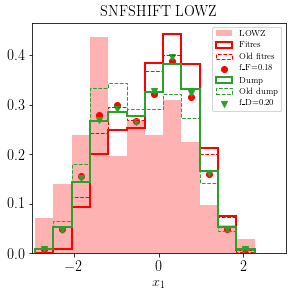

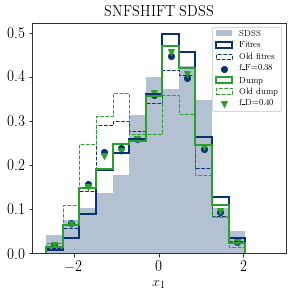

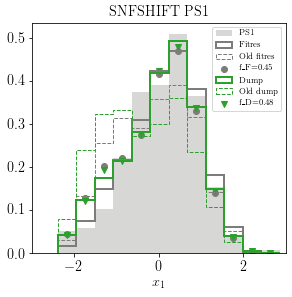

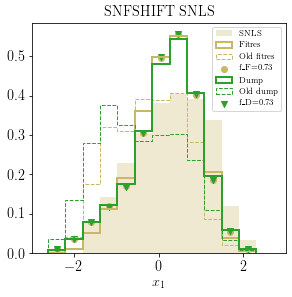

In [124]:
bins=12
survey='SDSS'

for survey in surveys[1:-1]:
    print(survey)
    fig = plt.figure(figsize=[4, 4])
    ax = fig.add_axes([0.1, 0.13, .88, .8])
    
    fitres = tools.Checker.read('/home/nicolas/Work/devpython/variaIa/Data/sims/' +
                                f'NN_COMBINE_FULL-SNFSHIFT/6_BIASCOR/' +
                                f'ALL_BIASCOR_NR_NR/output/OUTPUT_BBCFIT/' +
                                'FITOPT000_MUOPT002.FITRES')
    
    dump = pd.read_csv(f'../../../Data/sims/'+
                       f'NN_COMBINE_FULL-SNFSHIFT/1_SIM/' +
                       f'{survey}_DATA-NR/PIP_NN_FULL_NR-SNFSHIFT_{survey}_DATA-NR/' +
                       f'PIP_NN_FULL_NR-SNFSHIFT_{survey}_DATA-NR.DUMP',
                       delim_whitespace=True, skiprows=4).drop('VARNAMES:', axis=1)
    
    prop = {'density': True, 'histtype': 'step'}
    
    # FOR SUBLOWZ
    # lowz_df_th = [lowz_df.loc[lowz_df['IDSURVEY'] ==
    #                           tools.Checker.find_id['LOWZ'][i]]['x1']
    #               for i in range(len(np.unique(lowz_df['IDSURVEY'])))]
    # _, rng, _ = ax.hist(lowz_df_th, bins=bins,
    #                         density=True, color=['C2', 'C3', 'C4', 'C5'],
    #                         alpha=0.3,
    #                         label=['5', '64', '65', '66'],
    #                        stacked=True)
    
    # fitres_lowz = [fitres.loc[fitres['IDSURVEY'] == idsurv]['x1']
    #               for idsurv in np.unique(lowz_df['IDSURVEY'])]
    # ax.hist(fitres_lowz, bins=rng,
    #             density=True, histtype='step', lw=2,
    #             color=['C2', 'C3', 'C4', 'C5'],
    #             stacked=True)
    
    gen = stretchevol.generic()
    gen.set_model('Evol3G2M2S')
    baseTOT = gen.fit(df_nc.loc[df_nc['survey'] != 'LOWZ'])
    
    df_used = df_full.loc[~df_full['survey'].isin(['SNF', 'HST'])]
    df_used = df_used.loc[df_used['hostmass'] > 7]
    df_surv = df_used.loc[df_used['survey'] == survey]
    _, rng, _ = ax.hist(df_surv['stretchs'], bins=bins,
                        density=True, alpha=0.3,
                        color=colors[survey],
                        label=f'{survey}')
     
    fitres_surv = fitres.loc[fitres['IDSURVEY'].isin(tools.Checker.find_id[survey])]
    ax.hist(fitres_surv['x1'], bins=rng,
            **prop, lw=2, color=colors[survey], label='Fitres')
    ax.hist(fitres_surv.loc[fitres_surv['HOST_LOGsSFR'] == 0]['x1'], bins=rng,
            **prop, ls='--', lw=1, color=colors[survey], label='Old fitres')
    
    val, num = np.unique(fitres_surv['HOST_LOGsSFR'], return_counts=True)
    yFITRES = num[-1]/np.sum(num)
    print('%y in FITRES =', yFITRES)
    
    cbins = (rng[:-1] + rng[1:])/2
    pdfbase_bins = baseTOT.plot_a(cbins, f=yFITRES)
    ax.scatter(cbins, pdfbase_bins, color=colors[survey], label=f'f_F={yFITRES:.2f}')
    
    ax.hist(dump['S2x1'], bins=rng,
            **prop, lw=2, color='C2', label='Dump')
    ax.hist(dump.loc[dump['INPUTSSFR'] == 0]['S2x1'], bins=rng,
            **prop, ls='--', lw=1, color='C2', label='Old dump')
    
    val, num = np.unique(dump['INPUTSSFR'], return_counts=True)
    yDUMP = num[-1]/np.sum(num)
    print('%y in DUMP =', yDUMP)
    
    pdfbase_bins = baseTOT.plot_a(cbins, f=yDUMP)
    ax.scatter(cbins, pdfbase_bins, color='C2', marker='v', label=f'f_D={yDUMP:.2f}')
    
    ax.set_xlim([-3, 3])
    ax.set_xlabel(r'$x_1$', fontsize='x-large')
    
    #ax.legend(ncol=4, loc='lower center', bbox_to_anchor=[0.5, 1.02])
    ax.legend(fontsize='small')
    
    ax.set_title(f'SNFSHIFT {survey}', fontsize='x-large')
    
    fig.savefig(f'../../../Images/pdf/snana_diagnostic_hist_x1-panth_surv_NRSNFSHIFT-{survey}.pdf',
               bbox_inches='tight')
    fig.savefig(f'../../../Images/png/snana_diagnostic_hist_x1-panth_surv_NRSNFSHIFT-{survey}.png',
               dpi=600)

### Sigmoid compute and interp

In [23]:
print('lowz_min =', np.min(df_lowz_nohl.hostmass), 'lowz_max =', np.max(df_lowz_nohl.hostmass))
print('floor =', evol2G2M2S_SNF.floor, 'ceil =', evol2G2M2S_SNF.ceil)

lowz_min = 7.014 lowz_max = 11.906
floor = 7.0 ceil = 12.0


In [73]:
# np.mean(fitres_lowz['zCMB'])
z_mean

0.00952253573333334

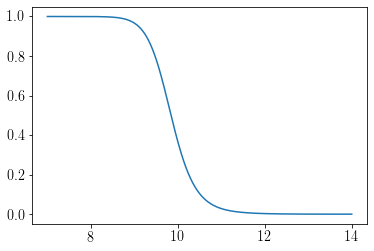

In [82]:
gen = massevol.generic()
gen.set_model('Evol2G2M2S')
evol2G2M2S_SNF = gen.fit(df_sed_snf)

# df_lowz_nohl = df_lowz.loc[df_lowz['hostmass'] > 7]
# z_mean = np.mean(df_lowz_nohl.redshifts)

# fitres = tools.Checker.read('/home/nicolas/Work/devpython/variaIa/Data/sims/' +
#                             f'NN_COMBINE_FULL-SNFSHIFT/6_BIASCOR/' +
#                             f'ALL_BIASCOR_NR_NR/output/OUTPUT_BBCFIT/' +
#                             'FITOPT000_MUOPT002.FITRES')
# fitres_lowz = fitres.loc[fitres['IDSURVEY'].isin(tools.Checker.find_id['LOWZ'])]
# z_mean = np.mean(fitres_lowz['zCMB'])

dump = pd.read_csv(f'../../../Data/sims/'+
                   f'NN_COMBINE_FULL-SNFSHIFT/1_SIM/' +
                   f'LOWZ_DATA-NR/PIP_NN_FULL_NR-SNFSHIFT_LOWZ_DATA-NR/' +
                   f'PIP_NN_FULL_NR-SNFSHIFT_LOWZ_DATA-NR.DUMP',
                   delim_whitespace=True, skiprows=4).drop('VARNAMES:', axis=1)
dump_cut = dump.loc[dump['GENZ'] < 0.1].copy()
z_mean = np.mean(dump_cut['GENZ'])

deltaz_mean = evol2G2M2S_SNF.delta(z_mean)

Mlin = np.linspace(evol2G2M2S_SNF.floor, evol2G2M2S_SNF.ceil+2, 3000) 
l_y = evol2G2M2S_SNF.plot_y(Mlin) 
l_o = evol2G2M2S_SNF.plot_o(Mlin) 
l_t = evol2G2M2S_SNF.plot_a(Mlin, z=z_mean)
yo = deltaz_mean*l_y/l_t

sig_func = scipy.interpolate.interp1d(Mlin, yo, kind='linear')

plt.plot(Mlin, yo)

# mass = df_lowz_nohl['hostmass']
# mass = fitres_lowz['HOST_LOGMASS']
# mass = dump_cut['LOGMASS_TRUE']
# mass = np.asarray(mass)
# 
# sig_list = sig_func(mass)
# 
# fig = plt.figure(figsize=[8, 8])
# ax = fig.add_axes([0.1, 0.13, .88, .8])
# 
# ax.hist(sig_list, align='right',
#          label=f'median = {np.median(sig_list):.2f}\n' +
#                f'mean = {np.mean(sig_list):.2f}\n' +
#                f'\%$a>0.5 =$ {len(sig_list[sig_list>0.5])/len(sig_list):.2f}')
# ax.set_xlabel('age')
# ax.set_ylabel('counts')
# # plt.title('SNF mass model on DATA')
# # plt.title('SNF mass model on FITRES')
# ax.set_title('SNF mass model on dump_cut')
# ax.legend()

# val, num = np.unique(fitres_lowz['HOST_LOGsSFR'], return_counts=True)
# print('%y in FITRES =', num[-1]/np.sum(num))

### Plot asymgaus color shape (PS1)

In [12]:
gen.set_model('Evol1G1M2S')
asym = gen.fit(df_nc)
c_lin = np.linspace(-0.3, 0.3, 1000)
casym = asym.likelihood_tot(c_lin, np.array([0. for i in range(len(c_lin))]),
                            -0.068, 0.034, 0.123)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/casym-lin.txt', c_lin)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/casym-val.txt', casym)

### Plot mass distribution of hostlib

In [8]:
samples = ['lowz', 'found', 'highz']

sm = ipw.Dropdown(options=samples,
                  description='Sample:',
                  value='lowz')

display(sm)

Dropdown(description='Sample:', options=('lowz', 'found', 'highz'), value='lowz')

In [9]:
hostlib = pd.read_csv('/home/nicolas/Work/devpython/variaIa/Data/hostlibs/'+
                      f'BP_{sm.value}.HOSTLIB', skiprows=[0], delim_whitespace=True)

In [10]:
ran_mass = hostlib['LOGMASS']#.sample(100000)

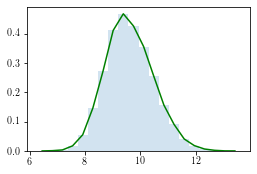

In [12]:
fig = plt.figure(figsize=[5, 2.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

histout = ax.hist(ran_mass, bins=20, density=True, alpha=0.2)
ax.plot((histout[1][:-1]+histout[1][1:])/2, histout[0], color='green')

In [18]:
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/mdist-lin.txt', (histout[1][:-1]+histout[1][1:])/2)
np.savetxt('/home/nicolas/Work/Articles/2022-PhD/Data/mdist-val.txt', histout[0])

### Plot curves before, after selection

In [5]:
lsurv = ['LOWZ', 'PS1', 'SDSS', 'SNLS']
dumptot = pd.read_csv('../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/DUMP/LOWZ_DATA.DUMP',
                      skiprows=5, delim_whitespace=True).drop('VARNAMES:', axis=1)
for s in lsurv[1:]:
    temp = pd.read_csv(f'../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/DUMP/{s}_DATA.DUMP',
                       skiprows=5, delim_whitespace=True).drop('VARNAMES:', axis=1)
    dumptot = dumptot.append(temp, ignore_index=True)

dumpass = dumptot[dumptot['SIM_SEARCHEFF_MASK']>0]
#dumptot

In [42]:
dumptot.columns

Index(['CID', 'SIM_SEARCHEFF_MASK', 'GENTYPE', 'SNTYPE', 'LOGMASS_TRUE',
       'GENZ', 'LIBID', 'RA', 'DECL', 'MWEBV', 'MWEBVMAP', 'MU', 'MJD0',
       'MAGT0_g', 'MAGT0_r', 'MAGT0_i', 'MAGT0_z', 'SNRMAX_g', 'SNRMAX_r',
       'SNRMAX_i', 'SNRMAX_z', 'SNRMAX', 'SNRMAX2', 'SNRMAX3', 'NOBS',
       'TRESTMIN', 'TRESTMAX', 'TGAPMAX', 'S2alpha', 'S2beta', 'S2x0', 'S2x1',
       'S2c'],
      dtype='object')

In [6]:
lsurv = ['LOWZ', 'PS1', 'SDSS', 'SNLS']
dumpsurv = dict()
dumpsass = dict()
for s in lsurv:
    dumpsurv[s] = pd.read_csv(f'../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/DUMP/{s}_DATA.DUMP',
                                skiprows=5, delim_whitespace=True).drop('VARNAMES:', axis=1)
    dumpsass[s] = dumpsurv[s][dumpsurv[s]['SIM_SEARCHEFF_MASK']>0]

### Curves after fit

In [7]:
fitall = tools.Checker.read('../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/LCFIT/LOWZ_DATA/FITOPT000.FITRES')
for s in lsurv[1:]:
    fitall = fitall.append(tools.Checker.read(
        f'../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/LCFIT/{s}_DATA/FITOPT000.FITRES'))

#fitall

In [34]:
fitall.columns

Index(['CID', 'IDSURVEY', 'TYPE', 'FIELD', 'CUTFLAG_SNANA', 'ERRFLAG_FIT',
       'zHEL', 'zHELERR', 'zCMB', 'zCMBERR', 'zHD', 'zHDERR', 'VPEC',
       'VPECERR', 'MWEBV', 'HOST_LOGMASS', 'HOST_LOGMASS_ERR', 'HOST_sSFR',
       'HOST_sSFR_ERR', 'PKMJDINI', 'SNRMAX1', 'SNRMAX2', 'SNRMAX3', 'PKMJD',
       'PKMJDERR', 'x1', 'x1ERR', 'c', 'cERR', 'mB', 'mBERR', 'x0', 'x0ERR',
       'COV_x1_c', 'COV_x1_x0', 'COV_c_x0', 'NDOF', 'FITCHI2', 'FITPROB',
       'SIM_TYPE_INDEX', 'SIM_TEMPLATE_INDEX', 'SIM_LIBID', 'SIM_NGEN_LIBID',
       'SIM_ZCMB', 'SIM_ZFLAG', 'SIM_VPEC', 'SIM_DLMAG', 'SIM_PKMJD', 'SIM_x1',
       'SIM_c', 'SIM_alpha', 'SIM_beta', 'SIM_gammaDM', 'SIM_x0', 'SIM_mB',
       'SIM_AV', 'SIM_RV'],
      dtype='object')

In [8]:
fitsurv = dict()
for s in lsurv:
    fitsurv[s] = tools.Checker.read(f'../../../Data/sims/outdated/NN_G10_PANTH-MSK66-BP_V5/LCFIT/{s}_DATA/FITOPT000.FITRES')

### Mass

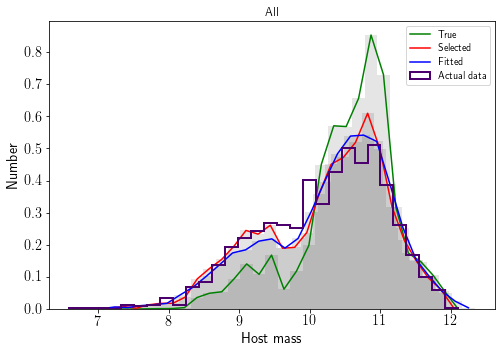

In [29]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
plt.rcParams['figure.facecolor'] = 'w'

histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}

toplot_all = {'surv': {},
              'sass': {},
              'fit': {}}
histout_all = {'LOWZ': {},
               'PS1': {},
               'SDSS': {},
               'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumptot, dumpass, fitall]
keyy = ['LOGMASS_TRUE', 'LOGMASS_TRUE', 'HOST_LOGMASS']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for tipe, df, key, c, label in zip(tipee, dff, keyy, cc, labell):
    toplot_all[tipe] = df[df[key] > 6][key]
    histout_all[tipe] = ax.hist(toplot_all[tipe], **histprop)
    ax.plot((histout_all[tipe][1][:-1]+histout_all[tipe][1][1:])/2,
            histout_all[tipe][0], color=c, label=label)

ax.hist(df_full[df_full['hostmass']>6]['hostmass'],
        bins=30, density=True, lw=2,
        histtype='step', color='xkcd:royal purple', label='Actual data')

ax.tick_params(labelsize='x-large')
ax.set_ylim(bottom=0)

ax.set_xlabel(r'Host mass', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend() 

ax.set_title('All')

fig.savefig(f'../../../Images/pdf/snana-hist_mass-all.pdf', bbox_inches='tight')

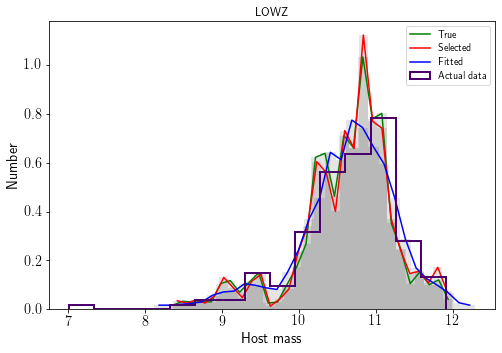

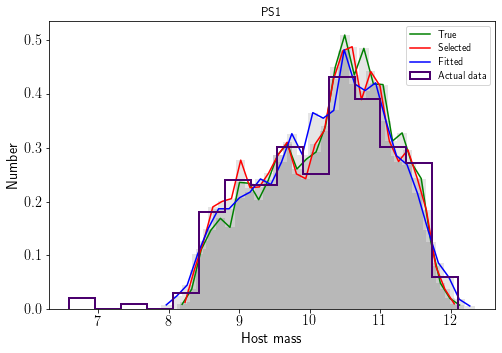

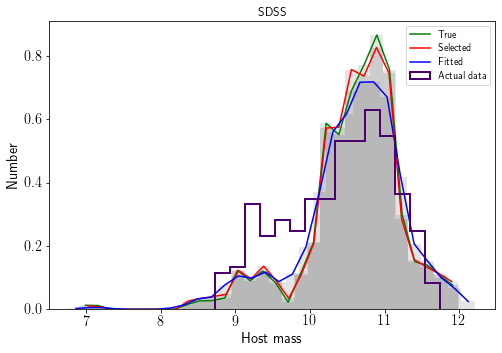

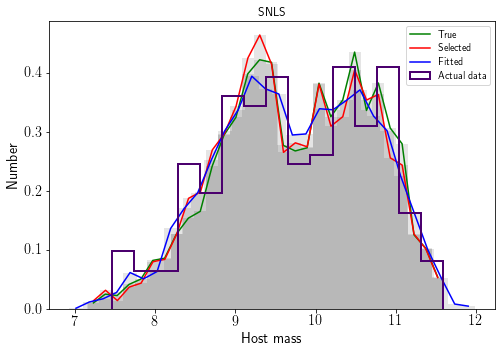

In [28]:
histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}

toplot = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}
histout = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumpsurv, dumpsass, fitsurv]
keyy = ['LOGMASS_TRUE', 'LOGMASS_TRUE', 'HOST_LOGMASS']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for s in lsurv:
    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    for tipe, df, key, c, l in zip(tipee, dff, keyy, cc, labell):
        toplot[s][tipe] = df[s][df[s][key] > 6][key]
        histout[s][tipe] = ax.hist(toplot[s][tipe], **histprop)
        ax.plot((histout[s][tipe][1][:-1]+histout[s][tipe][1][1:])/2,
                histout[s][tipe][0], color=c, label=l)
    ax.hist(df_full[df_full['survey']==s][
                    df_full[df_full['survey']==s]['hostmass']>6]['hostmass'],
            bins=15, density=True, lw=2,
            histtype='step', color='xkcd:royal purple',
            label='Actual data')
    ax.tick_params(labelsize='x-large')
    
    ax.set_xlabel(r'Host mass', fontsize='x-large')
    ax.set_ylabel(r'Number', fontsize='x-large')
    
    ax.legend() 
    
    ax.set_title(s)
    fig.savefig(f'../../../Images/pdf/snana-hist_mass-{s}.pdf', bbox_inches='tight')

### Stretch

Text(0.5, 1.0, 'All')

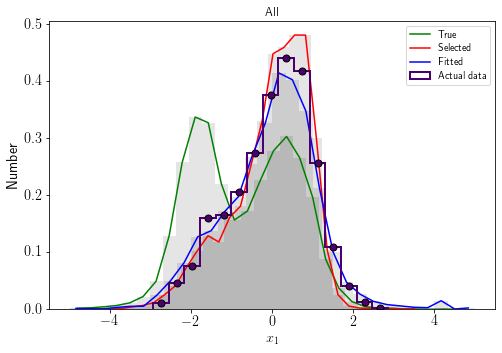

In [10]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}
prop = dict(marker="o", ms=7,
            ecolor="xkcd:royal purple", mew=1,
            mec="k", mfc="xkcd:royal purple", ls='none')

toplot_all = {'surv': {},
              'sass': {},
              'fit': {}}
histout_all = {'LOWZ': {},
               'PS1': {},
               'SDSS': {},
               'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumptot, dumpass, fitall]
keyy = ['S2x1', 'S2x1', 'x1']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for tipe, df, key, c, label in zip(tipee, dff, keyy, cc, labell):
    toplot_all[tipe] = df[df[key] > -6][key]
    histout_all[tipe] = ax.hist(toplot_all[tipe], **histprop)
    ax.plot((histout_all[tipe][1][:-1]+histout_all[tipe][1][1:])/2,
            histout_all[tipe][0], color=c, label=label)

hist_df = ax.hist(df_full[df_full['stretchs']>-6]['stretchs'],
                  bins=15, density=True, lw=2,
                  histtype='step', color='xkcd:royal purple', label='Actual data')

ax.errorbar((hist_df[1][:-1]+hist_df[1][1:])/2,
            hist_df[0],# yerr=np.sqrt(hist_df[s][0]),
            **prop)

ax.tick_params(labelsize='x-large')
ax.set_ylim(bottom=0)

ax.set_xlabel(r'$x_1$', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend() 

ax.set_title('All')

#fig.savefig(f'../../../Images/pdf/snana-hist_stretch-all.pdf', bbox_inches='tight')

### Plot models on top of green

In [16]:
baseTOT = stretchevol.Evol3G2M2S(df_nc)
baseTOT.minimize()
x_lin = np.linspace(-3, 3, 1000)

pdfmodels = {}
pdfmmodel = {}

for s in lsurv:
    pdfmodels[s] = baseTOT.likelihood_tot(baseTOT.delta(
                                               np.mean(dumpsurv['LOWZ']['GENZ'])),
                                           x_lin, 0, #np.mean(dx1),
                                           baseTOT.param['aa'],
                                           baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                           baseTOT.param['mu_2'], baseTOT.param['sigma_2'])
    #pdfmmodel[s] = np.mean(pdfmodels[s], axis=0)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/stretchevol.py:203: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  self.migrad_out = self.m_tot.migrad()


In [14]:
np.mean(dumpsurv['LOWZ']['GENZ'])

0.07418240317072018

In [15]:
baseTOT = stretchevol.Evol3G2M2S(df_nc)
baseTOT.minimize()
x_lin = np.linspace(-3, 3, 1000)

pdfmodel = baseTOT.likelihood_tot(baseTOT.delta(np.mean(dumpsurv['LOWZ']['GENZ'])),
                                           x_lin, 0, #np.mean(dx1),
                                           baseTOT.param['aa'],
                                           baseTOT.param['mu_1'], baseTOT.param['sigma_1'],
                                           baseTOT.param['mu_2'], baseTOT.param['sigma_2'])

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/variaIa-0.8.4-py3.7.egg/variaIa/stretchevol.py:203: IMinuitWarning: errordef not set, using 1 (appropriate for least-squares)
  self.migrad_out = self.m_tot.migrad()


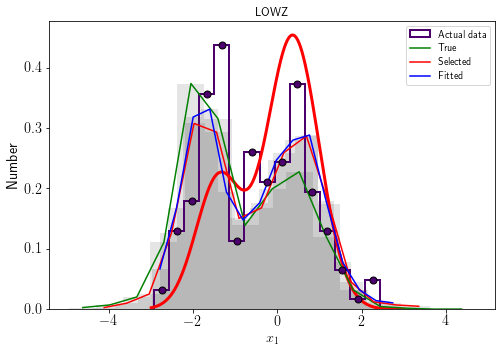

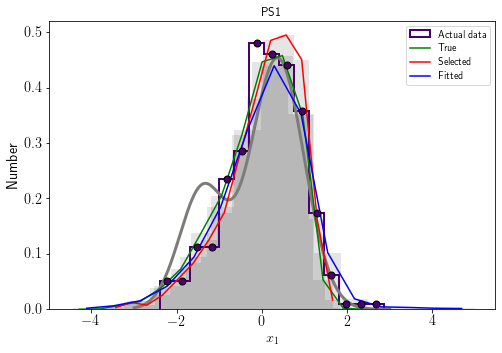

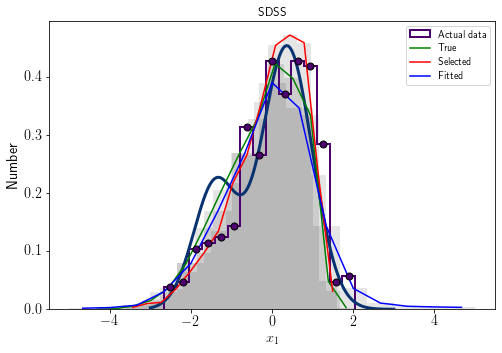

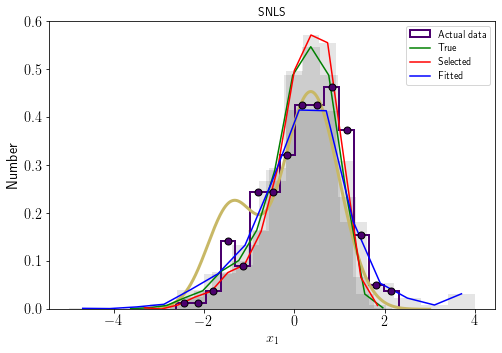

In [20]:
plt.rcParams['figure.facecolor'] = 'w'
histprop = {'bins':15, 'density':True, 'color':'k', 'alpha':.1}
prop = dict(marker="o", ms=7,
            ecolor="xkcd:royal purple", mew=1,
            mec="k", mfc="xkcd:royal purple", ls='none')

toplot = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}
histout = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}
df_plot = {}
hist_df = {}

tipee = ['surv', 'sass', 'fit']
dff = [dumpsurv, dumpsass, fitsurv]
keyy = ['S2x1', 'S2x1', 'x1']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for s in lsurv:
    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    
    df_plot[s] = df_full[df_full['survey']==s][\
                         df_full[df_full['survey']==s]['stretchs']>-6]['stretchs']
    hist_df[s] = ax.hist(df_plot[s],
                         bins=15, lw=2, density=True,
                         histtype='step', color='xkcd:royal purple',
                         label='Actual data')
    
    ax.plot(x_lin, pdfmodels[s], color=colors[s], lw=3)
    
    ax.errorbar((hist_df[s][1][:-1]+hist_df[s][1][1:])/2,
                 hist_df[s][0],# yerr=np.sqrt(hist_df[s][0]),
                **prop)
    
    for tipe, df, key, c, l in zip(tipee, dff, keyy, cc, labell):
        toplot[s][tipe] = df[s][df[s][key] > -6][key]
        histout[s][tipe] = ax.hist(toplot[s][tipe],
                                   #weights=[np.max(df_plot[s])
                                   #         for k in range(len(toplot[s][tipe]))],
                                   **histprop)
        ax.plot((histout[s][tipe][1][:-1]+histout[s][tipe][1][1:])/2,
                histout[s][tipe][0],#*len(df_plot[s]),
                color=c, label=l)

    ax.tick_params(labelsize='x-large')
    
    ax.set_xlabel(r'$x_1$', fontsize='x-large')
    ax.set_ylabel(r'Number', fontsize='x-large')

    ax.legend()
    
    ax.set_title(s)
    #plt.close()
    #fig.savefig(f'../../../Images/pdf/snana-hist_stretch-{s}.pdf', bbox_inches='tight')

In [46]:
x1_ks = {}

for s in lsurv:
    x1_ks[s] = scipy.stats.ks_2samp(toplot[s]['fit'], df_plot[s])[1]

In [47]:
x1_ks

{'LOWZ': 0.06920318724895858,
 'PS1': 0.6670183188591328,
 'SDSS': 0.031595438935562936,
 'SNLS': 0.2893316995194396}

### Color

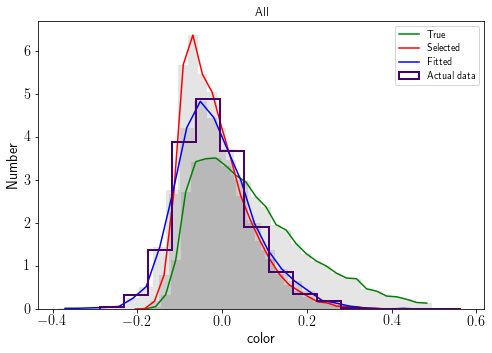

In [33]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}

toplot_all = {'surv': {},
              'sass': {},
              'fit': {}}
histout_all = {'LOWZ': {},
               'PS1': {},
               'SDSS': {},
               'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumptot, dumpass, fitall]
keyy = ['S2c', 'S2c', 'c']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for tipe, df, key, c, label in zip(tipee, dff, keyy, cc, labell):
    toplot_all[tipe] = df[(df[key] > -0.4) &
                          (df[key] < 0.6)][key]
    histout_all[tipe] = ax.hist(toplot_all[tipe], **histprop)
    ax.plot((histout_all[tipe][1][:-1]+histout_all[tipe][1][1:])/2,
            histout_all[tipe][0], color=c, label=label)
    
ax.hist(df_full[(df_full['colors']>-0.4) &
                (df_full['colors']<0.6)]['colors'],
        bins=15, density=True, lw=2,
        histtype='step', color='xkcd:royal purple', label='Actual data')
    
ax.tick_params(labelsize='x-large')
ax.set_ylim(bottom=0)

ax.set_xlabel(r'color', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend() 

ax.set_title('All')

fig.savefig(f'../../../Images/pdf/snana-hist_color-all.pdf', bbox_inches='tight')

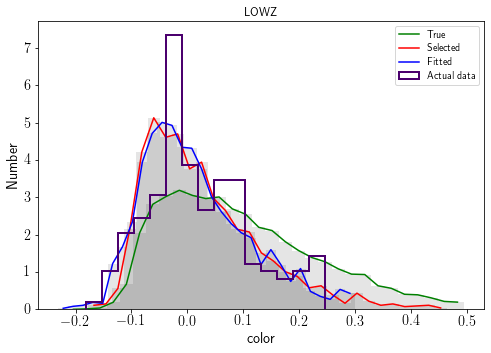

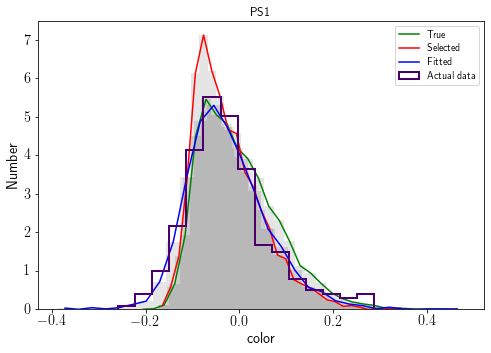

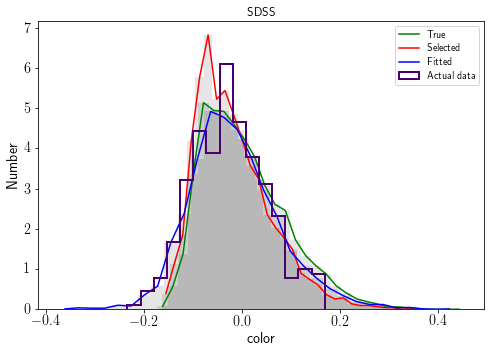

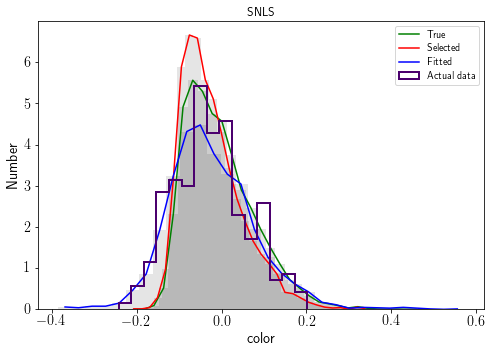

In [36]:
histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}

toplot = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}
histout = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumpsurv, dumpsass, fitsurv]
keyy = ['S2c', 'S2c', 'c']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for s in lsurv:
    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    for tipe, df, key, c, l in zip(tipee, dff, keyy, cc, labell):
        toplot[s][tipe] = df[s][(df[s][key] > -0.4) &
                               (df[s][key] < 0.6)][key]
        histout[s][tipe] = ax.hist(toplot[s][tipe], **histprop)
        ax.plot((histout[s][tipe][1][:-1]+histout[s][tipe][1][1:])/2,
                histout[s][tipe][0], color=c, label=l)
        
    ax.hist(df_full[df_full['survey']==s][
            df_full[df_full['survey']==s]['colors']>-0.4]['colors'],
    bins=15, density=True, lw=2,
    histtype='step', color='xkcd:royal purple',
    label='Actual data')
    
    ax.tick_params(labelsize='x-large')
        
    ax.set_xlabel(r'color', fontsize='x-large')
    ax.set_ylabel(r'Number', fontsize='x-large')
        
    ax.legend() 
        
    ax.set_title(s)
    
    fig.savefig(f'../../../Images/pdf/snana-hist_color-{s}.pdf', bbox_inches='tight')

### Redshift

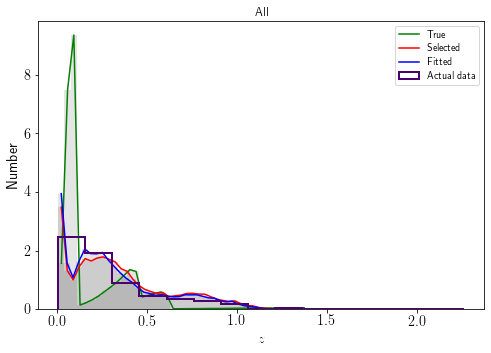

In [38]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

histprop = {'bins':40, 'density':True, 'color':'k', 'alpha':.1}

toplot_all = {'surv': {},
              'sass': {},
              'fit': {}}
histout_all = {'LOWZ': {},
               'PS1': {},
               'SDSS': {},
               'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumptot, dumpass, fitall]
keyy = ['GENZ', 'GENZ', 'zCMB']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for tipe, df, key, c, label in zip(tipee, dff, keyy, cc, labell):
    toplot_all[tipe] = df[key]
    histout_all[tipe] = ax.hist(toplot_all[tipe], **histprop)
    ax.plot((histout_all[tipe][1][:-1]+histout_all[tipe][1][1:])/2,
            histout_all[tipe][0], color=c, label=label)
    
ax.hist(df_full['redshifts'],
        bins=15, density=True, lw=2,
        histtype='step', color='xkcd:royal purple',
        label='Actual data')

ax.tick_params(labelsize='x-large')
ax.set_ylim(bottom=0)

ax.set_xlabel(r'$z$', fontsize='x-large')
ax.set_ylabel(r'Number', fontsize='x-large')

ax.legend() 

ax.set_title('All')

fig.savefig(f'../../../Images/pdf/snana-hist_redshift-all.pdf', bbox_inches='tight')

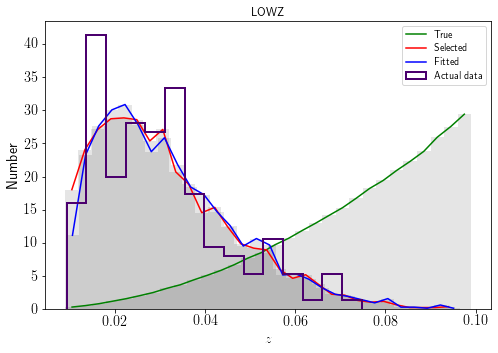

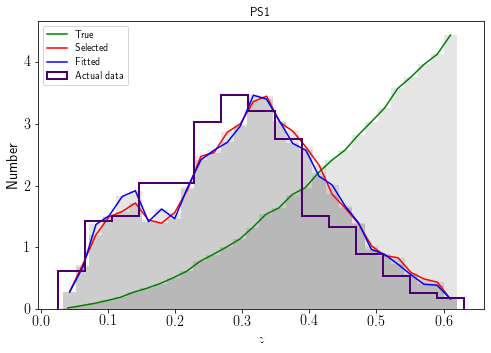

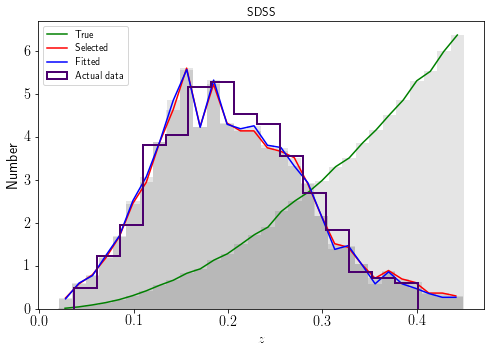

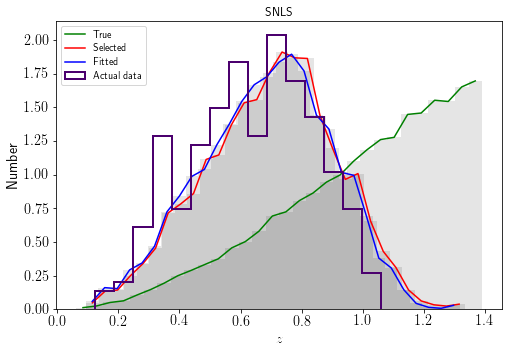

In [39]:
histprop = {'bins':30, 'density':True, 'color':'k', 'alpha':.1}

toplot = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}
histout = {'LOWZ': {},
          'PS1': {},
          'SDSS': {},
          'SNLS': {}}

tipee = ['surv', 'sass', 'fit']
dff = [dumpsurv, dumpsass, fitsurv]
keyy = ['GENZ', 'GENZ', 'zCMB']
cc = ['g', 'r', 'b']
labell = ['True', 'Selected', 'Fitted']

for s in lsurv:
    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
    for tipe, df, key, c, l in zip(tipee, dff, keyy, cc, labell):
        toplot[s][tipe] = df[s][key]
        histout[s][tipe] = ax.hist(toplot[s][tipe], **histprop)
        ax.plot((histout[s][tipe][1][:-1]+histout[s][tipe][1][1:])/2,
                histout[s][tipe][0], color=c, label=l)
        
    ax.hist(df_full[df_full['survey']==s]['redshifts'],
    bins=15, density=True, lw=2,
    histtype='step', color='xkcd:royal purple',
    label='Actual data')
        
    ax.tick_params(labelsize='x-large')
        
    ax.set_xlabel(r'$z$', fontsize='x-large')
    ax.set_ylabel(r'Number', fontsize='x-large')
        
    ax.legend() 
        
    ax.set_title(s)
    
    fig.savefig(f'../../../Images/pdf/snana-hist_redshift-{s}.pdf', bbox_inches='tight')

### Surveys' spec

In [243]:
sdspec = pd.read_csv('/home/nicolas/Work/Articles/2022-PhD/figures/sdss_spec.dat',
                     delim_whitespace=True)
ps1spec = pd.read_csv('/home/nicolas/Work/Articles/2022-PhD/figures/ps1_spec.dat',
                     delim_whitespace=True)
lowspec = pd.read_csv('/home/nicolas/Work/Articles/2022-PhD/figures/csp_spec.dat',
                     delim_whitespace=True)
snlspec = pd.read_csv('/home/nicolas/Work/Articles/2022-PhD/figures/snls_spec.dat',
                     delim_whitespace=True)

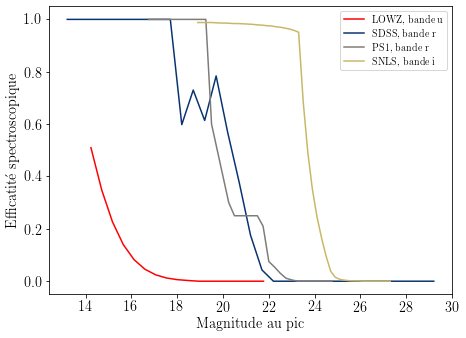

In [249]:
fig = plt.figure(figsize=[7, 5])
ax = fig.add_axes([0.1, 0.12, 0.80, 0.8])

for spec, survey in zip([lowspec, sdspec, ps1spec, snlspec], surveys[1:-1]):
    ax.plot(spec[spec.columns[0]], spec['SPECEFF'],
            color=colors[survey], label=f'{survey},\t bande {spec.columns[0]}')
    
ax.set_xlabel('Magnitude au pic')
ax.set_ylabel('Efficatité spectroscopique')

ax.legend()

fig.savefig('../../../Images/pdf/speceff-all.pdf', bbox_inches='tight')
fig.savefig('../../../Images/png/speceff-all.png', dpi=600)

### $\texttt{SALT2.4}$ time series and point band SDSS

Text(0, 0.5, 'Phase relative to $t_0$ (days)')

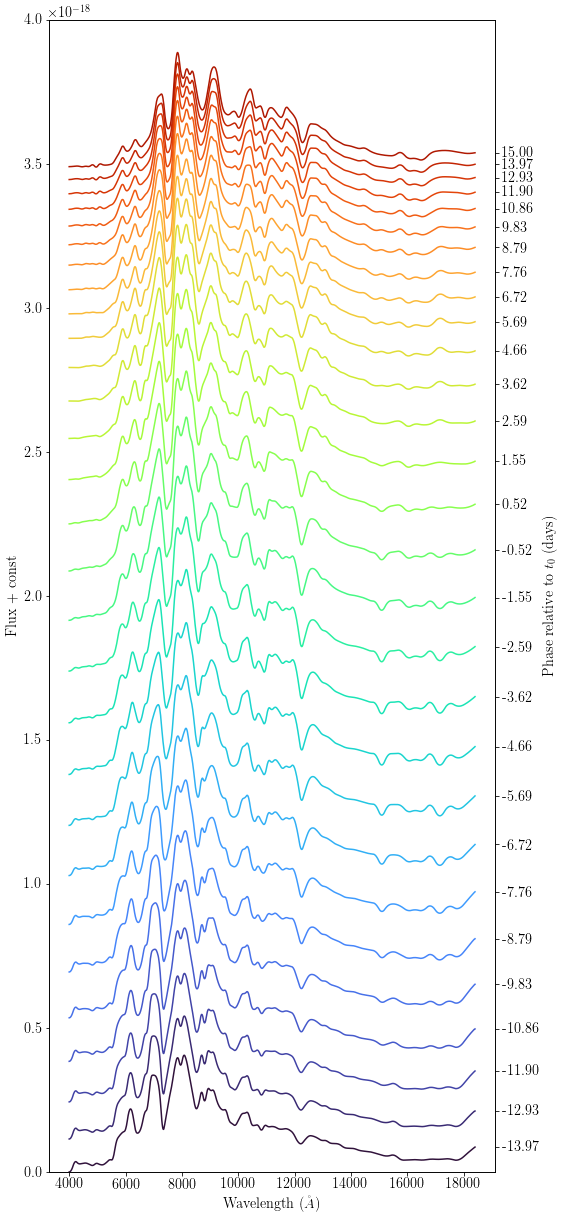

In [135]:
model = sncosmo.Model('salt2')
model.set(c=0.05, x1=0.5, z=1.0, t0=55100.)
model.set_source_peakabsmag(-19.36, 'sdssr', 'ab', cosmo=cdata)

t_lin = np.linspace(55100-15, 55100+15, 30)
w_lin = np.linspace(model.minwave(), model.maxwave(), 1000)
fluxes = {t_lin[i]: model.flux(time=t_lin[i], wave=w_lin)
          for i in range(len(t_lin))}
const=2.5e-19

fig = plt.figure(figsize=[10, 20])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
axd = ax.twinx()

cmap = plt.cm.get_cmap('turbo')
end_coords = []
end_labels = t_lin[1:]-55100
end_labels = list(map('{:.2f}'.format,end_labels))
for i,t in enumerate(t_lin[1:]):
    ax.plot(w_lin,
            fluxes[t]+0.3*i*np.max(fluxes[t_lin[i-1]]),
            color=cmap(i/len(t_lin)))
    end_coords.append(fluxes[t][-1]+0.3*i*np.max(fluxes[t_lin[i-1]]))

ax.tick_params(labelsize='x-large')
axd.set_yticks(end_coords)
#axd.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
axd.set_yticklabels(end_labels)
axd.tick_params(labelsize='x-large')

ax.set_ylim(0,4e-18)
axd.set_ylim(ax.get_ylim())

ax.set_xlabel(r'Wavelength ($\AA$)', fontsize='x-large')
ax.set_ylabel('Flux + const', fontsize='x-large')
axd.set_ylabel(r'Phase relative to $t_0$ (days)', fontsize='x-large')

#fig.savefig('/home//nicolas/Work/Articles/2022-PhD/Figures/timeseries.pdf', bbox_inches='tight')
#fig.savefig('../../../Images/pdf/timeseries.pdf', bbox_inches='tight')

Text(0, 0.5, 'Transmission')

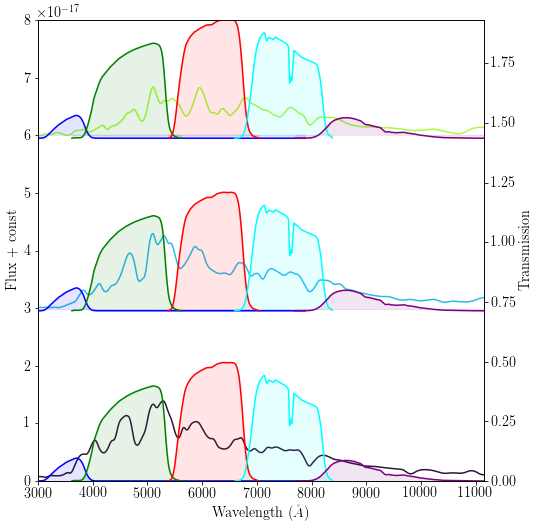

In [454]:
model = sncosmo.Model('salt2')
model.set(c=0.05, x1=0.5, z=0.3, t0=55100.)
model.set_source_peakabsmag(-19.36, 'sdssr', 'ab', cosmo=cdata)

t_lin = np.linspace(55100-15, 55100+15, 4)
w_lin = np.linspace(model.minwave(), model.maxwave(), 1000)
fluxes = {t_lin[i]: model.flux(time=t_lin[i], wave=w_lin)
          for i in range(len(t_lin))}
const=2.5e-19

fig = plt.figure(figsize=[10, 8])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])
axd = ax.twinx()

cmap = plt.cm.get_cmap('turbo')

for i,t in enumerate(t_lin[1:]):
    ax.plot(w_lin,
            fluxes[t]+i*3e-17,
            color=cmap(i/len(t_lin)))
    for f,c in zip(['u', 'g', 'r', 'i', 'z'],
                   ['b', 'g', 'r', 'cyan', 'purple']):
        b = sncosmo.get_bandpass(f'sdss{f}')
        shift = [0, 0.72, 1.45]
        axd.plot(b.wave, 0.99*(b.trans+shift[i]),
                label=f'sdss{f}', color=c)
        axd.fill_between(b.wave, 0.99*(b.trans+shift[i]),
                         [shift[i] for j in range(len(b.trans))],
                         color=c, alpha=.1)

ax.tick_params(labelsize='x-large')
axd.tick_params(labelsize='x-large')

ax.set_xlim(3000, np.max(b.wave))
ax.set_ylim(0,80e-18)
axd.set_ylim(0, 1.93)

ax.set_xlabel(r'Wavelength ($\AA$)', fontsize='x-large')
ax.set_ylabel('Flux + const', fontsize='x-large')

axd.set_ylabel('Transmission', fontsize='x-large')

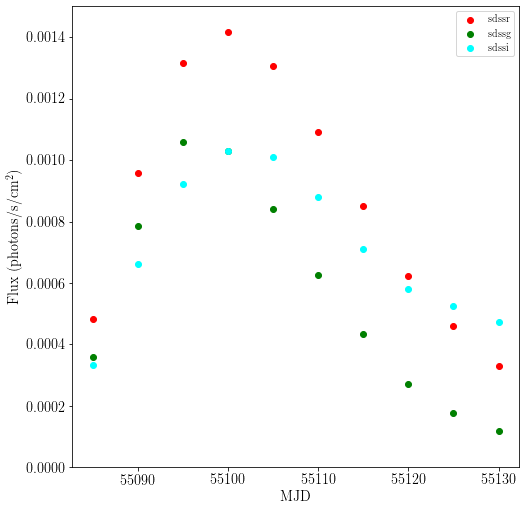

In [157]:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

t_lin = np.linspace(55100-15, 55100+30, 10)

for band,c in zip(['sdssr', 'sdssg', 'sdssi'],
                  ['r', 'g', 'cyan']):
    ax.scatter(t_lin, model.bandflux(band, t_lin),
           c=c, label=band)

ax.tick_params(labelsize='x-large')
ax.set_ylim(0,0.0015)

ax.set_xlabel(r'MJD', fontsize='x-large')
ax.set_ylabel(r'Flux (photons/s/cm$^2$)', fontsize='x-large')

ax.legend()

### Bands of surveys

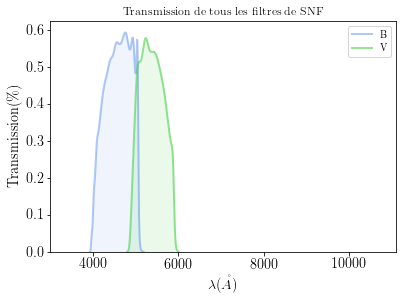

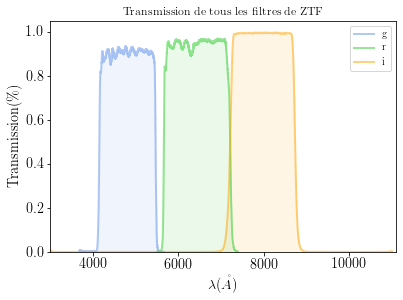

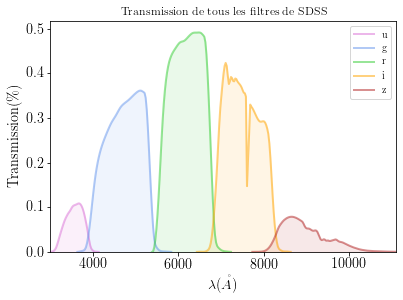

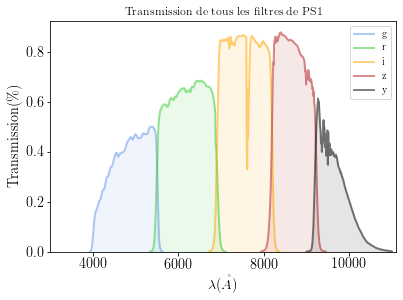

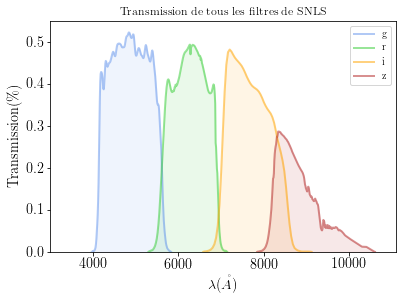

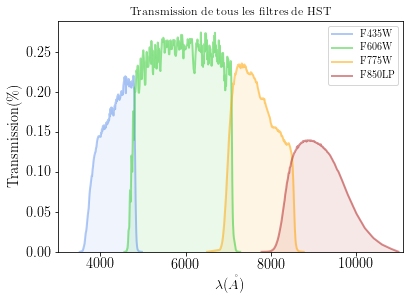

In [6]:
bcolors = {'u': 'orchid',
           'g': 'cornflowerblue', 'B': 'cornflowerblue', 'F435W': 'cornflowerblue',
           'r': 'limegreen', 'V': 'limegreen', 'F606W': 'limegreen',
           'i': 'orange', 'F775W': 'orange',
           'z': 'firebrick', 'F850LP': 'firebrick',
           'y': 'black'}

tcorr = {'SNF': 'LaSilla',
         'ZTF': 'Palomar',
         # 'LOWZ': ''
         'SDSS': 'SLOAN',
         'PS1': 'PAN-STARRS',
         'SNLS': 'CFHT',
         'HST': 'HST'}
tdict = {'LaSilla': 'COMBO17',
         # LOWZ
         'Palomar': 'ZTF',
         'SLOAN': 'SDSS',
         'PAN-STARRS': 'PS1',
         'CFHT': 'MegaCam',
         'HST': 'ACS_HRC'}
fdict = {'LaSilla': ['B', 'V'],
         # LOWZ
         'Palomar': ['g', 'r', 'i'],
         'SLOAN': ['u', 'g', 'r', 'i', 'z'],
         'PAN-STARRS': ['g', 'r', 'i', 'z', 'y'],
         'CFHT': ['g_1', 'r_1', 'i_1', 'z_1'],
         'HST': ['F435W', 'F606W', 'F775W', 'F850LP']}
filters = {survey: [tcorr[survey]+'/'+tdict[tcorr[survey]]+'.'+f for f in fdict[tcorr[survey]]]
           for survey in tcorr.keys()}
transdict = {survey: [SvoFps.get_transmission_data(f) for f in filters[survey]]
             for survey in tcorr.keys()}

for survey in tcorr.keys():
    fig = plt.figure(figsize=[6, 4])
    ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
    for i, tf in enumerate(zip(transdict[survey],
                           fdict[tcorr[survey]])):
        dist, = ax.plot(tf[0]['Wavelength'],
                        tf[0]['Transmission'],
                        color=bcolors[tf[1].split('_')[0]], linewidth=2, alpha=0.5,
                        label=tf[1].split('_')[0])
        ax.fill_between(tf[0]['Wavelength'],
                        tf[0]['Transmission'],
                        color=bcolors[tf[1].split('_')[0]], alpha=0.1)
    
    ax.set_xlabel('$\lambda (\mathring{A})$')
    ax.set_xlim(3000, 11100)
    ax.set_ylabel('Transmission(\%)')
    ax.set_ylim(bottom=0)
    ax.set_title(f'Transmission de tous les filtres de {survey}')
    ax.legend()
    fig.savefig(f'../../../Images/pdf/bands_{survey}.pdf', bbox_inches='tight')
    fig.savefig(f'../../../Images/png/bands_{survey}.png', dpi=600)

#### Save SNLS's bandpasses as an `sncosmo` bandpass

In [1046]:
psfdict = {'SNLS': {'g': 0.5,
                    'r': 1.0,
                    'i': 1.0,
                    'z': 1.0}}
for b, t in zip(fdict[tcorr['SNLS']], transdict['SNLS']):
    b = b.split('_')[0]
    p = psfdict['SNLS'][b]
    if 'g' in b:
        t = SvoFps.get_transmission_data('CFHT/MegaCam.g')
        sncosmo.register(sncosmo.Bandpass(t['Wavelength'], t['Transmission'],
                                          name=f'snls{b}'), force=True)
    else:
        sncosmo.register(sncosmo.Bandpass(t['Wavelength'], t['Transmission'],
                                          name=f'snls{b}'), force=True)
    # sncosmo.register(sncosmo.bandpasses.get_bandpass(f'megacampsf::{b}', p),
    #                  name=f'megacampsf::{b}', force=True)

### Plot actual LC with model

#### Load Pantheon data

In [634]:
pantheon_filename = '../../../Data/sne/ancillary_g10_n.FITRES'
with open(pantheon_filename) as f:
    for i, line in enumerate(f):
        if line.startswith('VARNAMES:'):
            line = line.replace(',', ' ')
            line = line.replace('\n', '')
            names = line.split()
        elif line.startswith(('SN', 'ROW')):
            startrows = i
            break
d = pd.read_csv(pantheon_filename, header=None,
                names=names, skiprows=startrows,
                delim_whitespace=True, comment='#')
d = d.drop('VARNAMES:', axis=1)

#### Load SDSS head and phot

In [159]:
hdul = fits.open('../../../Data/sims/lcmerge/SDSS_allCandidates+BOSS/SDSS_allCandidates+BOSS_HEAD.FITS.gz')

In [188]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  230 / width of table in bytes                        
NAXIS2  =                10258 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   50 / number of fields in each row                   
TTYPE1  = 'SNID    '           / label for field   1                            
TFORM1  = '16A     '           / data format of field: ASCII Character          
TUNIT1  = '        '           / physical unit of field                         
TTYPE2  = 'IAUC    '           / label for field   2                            
TFORM2  = '16A     '        

In [167]:
sdsslc = fits.open('../../../Data/sims/lcmerge/SDSS_allCandidates+BOSS/SDSS_allCandidates+BOSS_PHOT.FITS.gz')

In [179]:
sdsslc[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  102 / width of table in bytes                        
NAXIS2  =              1120566 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   19 / number of fields in each row                   
TTYPE1  = 'MJD     '           / label for field   1                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT1  = '        '           / physical unit of field                         
TTYPE2  = 'FLT     '           / label for field   2                            
TFORM2  = '2A      '        

#### Find SNe from its SDSS name in Pantheon

In [1057]:
sname = '2005gg'
snind = list(hdul[1].data['IAUC']).index(sname)
sncid = int(hdul[1].data['SNID'][snind])
dind = list(d['CIDint']).index(int(sncid))
did = d.loc[dind]
cid, t0, tmin, tmax, x0, z, x, c = did[['CIDint', 'PKMJD', 'TrestMIN', 'TrestMAX',
                                        'x0', 'zCMB', 'x1', 'c']]

#### Take dict of values from PHOT

In [1058]:
pkmjd, indmin, indmax, zsn, mwebv = hdul[1].data['PEAKMJD'][snind], \
                                    hdul[1].data['PTROBS_MIN'][snind], \
                                    hdul[1].data['PTROBS_MAX'][snind], \
                                    hdul[1].data['REDSHIFT_FINAL'][snind], \
                                    hdul[1].data['MWEBV'][snind]
lcdict = {param: [lc[param] for lc in sdsslc[1].data[indmin-1:indmax]]
          for param in ['MJD', 'FLT', 'MAG', 'MAGERR']}
lcdict['Trest'] = [mjd-pkmjd for mjd in lcdict['MJD']]
lcdf = pd.DataFrame.from_dict(lcdict)

#### Put parameters for `sncosmo` model and make model

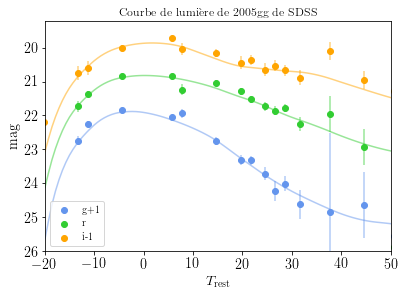

In [1059]:
model = sncosmo.Model('salt2', effects=[sncosmo.CCM89Dust()],
                               effect_names=['mw'],
                               effect_frames=['obs'])
model.set(c=c, x1=x, z=z, t0=t0, x0=x0, mwebv=mwebv)
model.set_source_peakabsmag(-19.36, 'sdssr', 'ab', cosmo=cdata)
t_lin = np.linspace(t0-20, t0+50, 100)

fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

bcolors = {'u': 'orchid',
           'g': 'cornflowerblue', 'B': 'cornflowerblue', 'F435W': 'cornflowerblue',
           'r': 'limegreen', 'V': 'limegreen', 'F606W': 'limegreen',
           'i': 'orange', 'F775W': 'orange',
           'z': 'firebrick', 'F850LP': 'firebrick',
           'y': 'black'}

bands = ['g', 'r', 'i']

for band, color, os in zip(['sdss' + b for b in bands],
                           [bcolors[b] for b in bands],
                           [1, 0, -1]):
    ax.plot(t_lin-t0, model.bandmag(band, 'ab', t_lin)+os,
           color=color, alpha=.5)#, label=band)

for band, color, os, lb in zip(bands,
                               [bcolors[b] for b in bands],
                               [1, 0, -1],
                               ['+1', '', '-1']):
    lc_used = lcdf.loc[lcdf['FLT'] == band]
    ax.scatter(lc_used['Trest'], lc_used['MAG']+os,
               color=color, label=f'{band}{lb}')
    ax.errorbar(lc_used['Trest'], lc_used['MAG']+os, yerr=lc_used['MAGERR'],
                color=color, ls='None', alpha=.5)

ax.set_xlabel(r'$T_{\rm rest}$')
ax.set_ylabel('mag')

ax.set_xlim(-20, +50)
ax.set_ylim(top=26)
ax.invert_yaxis()

ax.set_title(f'Courbe de lumière de {sname} de SDSS')

ax.legend(loc='lower left')

fig.savefig(f'../../../Images/pdf/lc_{sname}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/lc_{sname}.png', dpi=600)

#### Reverse: take a Pantheon data and find its LC

#### Load HEAD and PHOTS of all

In [1060]:
LCdict = {'LOWZ': {type: fits.open('../../../Data/sims/lcmerge/Pantheon/' +
                                   f'Pantheon_LOWZ_FITS/PS1_LOWZ_COMBINED_FITS_{type}.FITS')
                  for type in ['HEAD', 'PHOT']},
          'SDSS': {type: fits.open('../../../Data/sims/lcmerge/SDSS_allCandidates+BOSS/' +
                                   f'SDSS_allCandidates+BOSS_{type}.FITS.gz')
                  for type in ['HEAD', 'PHOT']},
          # 'PS1': {type: fits.open('../../../Data/sims/lcmerge/PS1MD_Jones18/' +
          #                          f'PS1MD_Jones18_{type}.FITS.gz')
          #         for type in ['HEAD', 'PHOT']},
          'PS1': {type: fits.open('../../../Data/sims/lcmerge/Pantheon/' +
                                   f'Pantheon_PS1MD_FITS/Pantheon_PS1MD_FITS_{type}.FITS')
                  for type in ['HEAD', 'PHOT']},
          # 'SNLS': {type : fits.open('../../../Data/sims/lcmerge/SNLS3year/' +
          #                          f'SDSS_allCandidates+BOSS_{type}.FITS.gz')
          #         for type in ['HEAD', 'PHOT']},
          'HST': {type: fits.open('../../../Data/sims/lcmerge/Pantheon/' +
                                   f'Pantheon_HST_FITS/PS1_HST_COMBINED_FITS_{type}.FITS')
                  for type in ['HEAD', 'PHOT']}}
snls_l = glob.glob('../../../Data/sims/lcmerge/SNLS3year/SNLS3year_MEGACAM/*.dat')
snlsid = [dat.split('_')[-1].split('.')[0] for dat in snls_l]


#### Take sub DataFrame from Pantheon, then a CID at random, and take its parameters

In [1063]:
survey = 'PS1'
d_used = d.loc[d['IDSURVEY'].isin(find_id[survey])]
ranid = random.choice(list(d_used['CID']))
ranid = '04D1hx'
ranid = '550041'
did = d_used.loc[d_used['CID'] == ranid]
cid, t0, tmin, tmax, x0, z, x, c = did[['CID', 'PKMJD', 'TrestMIN', 'TrestMAX',
                                        'x0', 'zCMB', 'x1', 'c']].values[0]

z = 0.2588


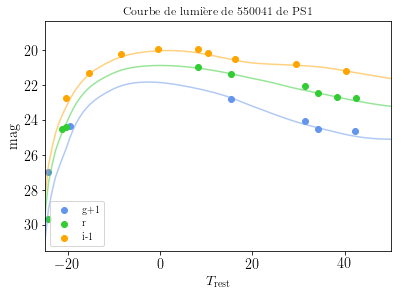

In [1064]:
#### Find it in LCdict
if survey != 'SNLS':
    h_used = LCdict[survey]['HEAD'][1]
    # if survey == 'PS1':
    #     snind = list(h_used.data['SNID']).index('PSc'+cid)
    # else:
    #     snind = list(h_used.data['SNID']).index(cid)
    snind = list(h_used.data['SNID']).index(cid)
    pkmjd, indmin, indmax, zsn, mwebv = h_used.data['PEAKMJD'][snind], \
                                        h_used.data['PTROBS_MIN'][snind], \
                                        h_used.data['PTROBS_MAX'][snind], \
                                        h_used.data['REDSHIFT_FINAL'][snind], \
                                        h_used.data['MWEBV'][snind]
    l_used = LCdict[survey]['PHOT'][1]
    # if survey == 'PS1':
    #     lcdict = {param: [lc[param] for lc in l_used.data[indmin-1:indmax]]
    #               for param in ['MJD', 'FLT', 'FLUXCAL', 'FLUXCALERR', 'ZEROPT']}
    # else:
    #     lcdict = {param: [lc[param] for lc in l_used.data[indmin-1:indmax]]
    #               for param in ['MJD', 'FLT', 'MAG', 'MAGERR']}
    lcdict = {param: [lc[param] for lc in l_used.data[indmin-1:indmax]]
              for param in ['MJD', 'FLT', 'MAG', 'MAGERR']}
    lcdict['Trest'] = [mjd-pkmjd for mjd in lcdict['MJD']]
    lcdf = pd.DataFrame.from_dict(lcdict)
    lcdf = lcdf.loc[~np.isnan(lcdf['MAG'])]
else:
    snlslc = snls_l[snlsid.index(cid)]
    with open(snlslc) as f:
        data_lines = [line for line in f if
                     ('MWEBV' in line) or
                     ('FINAL' in line) or
                     ('SEARCH' in line)]
        pnames = [re.split(':', line)[0] for line in data_lines]
        pvals = [float(re.split(' ', re.split(':',
                                              line)[-1].replace('\n',
                                                                ''))[1])
                 for line in data_lines]
        data = {name: pvals[i]
               for i, name in enumerate(pnames)}
        for i, line in enumerate(f):
            if line.startswith('VARLIST:'):
                print(i)
                line = line.replace(',', ' ')
                line = line.replace('\n', '')
                names = line.split()
            elif line.startswith('OBS'):
                startrows = i
                break
    pkmjd, zsn, mwebv = data['SEARCH_PEAKMJD'], data['REDSHIFT_FINAL'], data['MWEBV']
    lcdf = pd.read_csv(snlslc, header=None,
                       names=names, skiprows=startrows,
                       delim_whitespace=True, comment='#')
    lcdf = lcdf.drop('VARLIST:', axis=1)
    lcdf = lcdf.loc[(lcdf['SNR'] > 0) & (lcdf['MAGERR'] > 0)]
    lcdf['Trest'] = [mjd-pkmjd for mjd in lcdf['MJD']]

#### Put parameters for `sncosmo` model and make model
preband = {'LOWZ': 'csp',
           'SDSS': 'sdss',
           'PS1':  'ps1::',
           #'SNLS': 'megacampsf::',
           'SNLS': 'snls',
           'HST':  ''}
bands = {'LOWZ': ['g', 'i'],
         'SDSS': ['g', 'r', 'i'],
         'PS1':  ['g', 'r', 'i'],
         'SNLS': ['g', 'r', 'i', 'z'],
         'HST':  ['f435w', 'f606w', 'f775w', 'f850lp']}
offsets = {'LOWZ': [1, 0, -1],
           'SDSS': [1, 0, -1],
           'PS1':  [1, 0, -1],
           'SNLS': [1, 0.25, -0.25, -1],
           'HST':  [1, 0.25, -0.25, -1]}
magsys = {'SNLS': 'ab',
          'SDSS': 'ab',
          'PS1': 'ab',
          'HST': 'ab'}
labels = {'LOWZ': ['+1', '', '-1'],
          'SDSS': ['+1', '', '-1'],
          'PS1':  ['+1', '', '-1'],
          'SNLS': ['+1', '+.25', '-0.25', '-1'],
          'HST':  ['+1', '+.25', '-0.25', '-1']}
bcolors = {'u': 'orchid',
           'g': 'cornflowerblue', 'b': 'cornflowerblue', 'f435w': 'cornflowerblue',
           'r': 'limegreen', 'v': 'limegreen', 'f606w': 'limegreen',
           'i': 'orange', 'f775w': 'orange',
           'z': 'firebrick', 'f850lp': 'firebrick',
           'y': 'black'}

model = sncosmo.Model('salt2', effects=[sncosmo.CCM89Dust()],
                               effect_names=['mw'],
                               effect_frames=['obs'])
model.set(c=c, x1=x, z=z, t0=t0, x0=x0, mwebv=mwebv)
model.set_source_peakabsmag(-19.36, preband[survey]+bands[survey][1],
                            magsys[survey], cosmo=cdata)
tmin = 25
tmax = 50
t_lin = np.linspace(t0-tmin, t0+tmax, 100)

fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

for band, color, os in zip([preband[survey] + b for b in bands[survey]],
                           [bcolors[b] for b in bands[survey]],
                           offsets[survey]):
    if survey == 'PS1':
        pass
        # ax.plot(t_lin-t0, model.bandflux(band, t_lin)+os,
        #                                  #zp=sncosmo.get_magsystem(magsys[survey]).zpbandflux(band),
        #                                  #zpsys=magsys[survey])+os,
        #        color=color, alpha=.5)#, label=band)
        ax.plot(t_lin-t0, model.bandmag(band, magsys[survey], t_lin)+os,
               color=color, alpha=.5)#, label=band)
    elif survey == 'HST':
        pass
    else:
        ax.plot(t_lin-t0, model.bandmag(band, magsys[survey], t_lin)+os,
               color=color, alpha=.5)#, label=band)

for band, color, os, lb in zip(bands[survey],
                               [bcolors[b] for b in bands[survey]],
                               offsets[survey],
                               labels[survey]):
    lc_used = lcdf.loc[lcdf['FLT'] == band]
    if survey == 'PS1':
        ax.scatter(lc_used['Trest'], lc_used['MAG']+32.5+os,
                   color=color, label=f'{band}{lb}')
        ax.errorbar(lc_used['Trest'], lc_used['MAG']+31.5+os, yerr=lc_used['MAGERR'],
                    color=color, ls='None', alpha=.5)
    else:
        ax.scatter(lc_used['Trest'], lc_used['MAG']+os,
                   color=color, label=f'{band}{lb}')
        ax.errorbar(lc_used['Trest'], lc_used['MAG']+os, yerr=lc_used['MAGERR'],
                    color=color, ls='None', alpha=.5)

ax.set_xlabel(r'$T_{\rm rest}$')
# if survey == 'PS1':
#     ax.set_ylabel(r'Flux (photons$\cdot s^{-1}\cdot \mathrm{cm}^{-2}$)')
# else:
#     ax.set_ylabel('mag')
ax.set_ylabel('mag')

ax.set_xlim(-tmin, +tmax)
#ax.set_ylim(top=26)
# ax.set_ylim(bottom=-30)
# if survey != 'PS1':
ax.invert_yaxis()

# ax.set_title(f'{sname} ou {sncid}')

ax.legend(loc='lower left')
ax.set_title(f'Courbe de lumière de {cid} de {survey}')

print(r'z =', z)
fig.savefig(f'../../../Images/pdf/lc_{cid}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/lc_{cid}.png', dpi=600)

## Do for ZTF

In [4]:
d_ztf = pd.read_csv('../../../Data/sne/ztf_full.csv')

In [5]:
cid = random.choice(d_ztf['ztfname'])
#cid = 'ZTF18abixjey'
#cid = 'ZTF19aawgfnn'
cid = 'ZTF19aantarc'
#cid = 'ZTF20acwphpqb'
lc = sample.get_target_lightcurve(cid)
lcdf = lc.get_sncosmotable()
fit = lc.fit_salt_perfilter()

z = 0.099


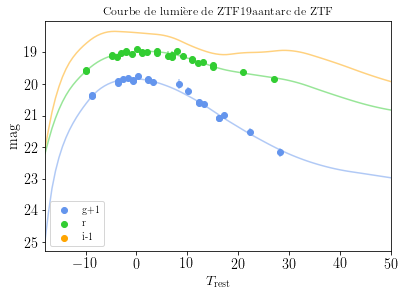

In [6]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

survey = 'ZTF'
preband = 'ztf'
bands = ['g', 'r', 'i']
offsets = [1, 0, -1]
#offsets = [0, 0, 0]
magsys = 'ab'
labels = ['+1', '', '-1']
bcolors = {'u': 'orchid',
           'g': 'cornflowerblue', 'b': 'cornflowerblue', 'f435w': 'cornflowerblue',
           'r': 'limegreen', 'v': 'limegreen', 'f606w': 'limegreen',
           'i': 'orange', 'f775w': 'orange',
           'z': 'firebrick', 'f850lp': 'firebrick',
           'y': 'black'}

tmin = 18
tmax = 50

for band, color, os, lb in zip(bands,
                               [bcolors[b] for b in bands],
                               offsets,
                               labels):
    c, mwebv, mwr_v, t0, x0, x, z = fit['values']['p48'+band]
    # lc_used = lcdf.loc[(lcdf['filter'] == preband+band) & (lcdf['mag'] < 99)].copy()
    lc_used = lcdf.loc[lcdf['band'] == 'p48'+band].copy()
    lc_used['Trest'] = lc_used['time']-t0
    model = sncosmo.Model('salt2', effects=[sncosmo.CCM89Dust()],
                                   effect_names=['mw'],
                                   effect_frames=['obs'])
    model.set(c=c, x1=x, z=z, t0=t0, x0=x0, mwebv=mwebv)
    #model.set_source_peakabsmag(-19.36, preband+'r',
    #                            magsys, cosmo=cdata)
    ax.scatter(lc_used['Trest'], lc_used['mag']+os,
               color=color, label=f'{band}{lb}')
    ax.errorbar(lc_used['Trest'], lc_used['mag']+os,
                yerr=lc_used['mag_err'],
                color=color, ls='None', alpha=.5)
    
    t_lin = np.linspace(t0-tmin, t0+tmax, 100)
    ax.plot(t_lin-t0, model.bandmag(preband+band, magsys, t_lin)+os,
           color=color, alpha=.5)#, label=band)

ax.set_xlabel(r'$T_{\rm rest}$')
ax.set_ylabel('mag')

ax.set_xlim(-tmin, +tmax)
#ax.set_ylim(bottom=16)
ax.invert_yaxis()

ax.legend(loc='lower left')
ax.set_title(f'Courbe de lumière de {cid} de {survey}')

print(r'z =', z)
# fig.savefig(f'../../../Images/pdf/lc_{cid}.pdf', bbox_inches='tight')
# fig.savefig(f'../../../Images/png/lc_{cid}.png', dpi=600)

/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ztfidr-0.5.1-py3.7.egg/ztfidr/lightcurve.py:344: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ztfidr-0.5.1-py3.7.egg/ztfidr/lightcurve.py:344: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/nicolas/.installs/anaconda3/lib/python3.7/site-packages/ztfidr-0.5.1-py3.7.egg/ztfidr/lightcurve.py:344: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


z = 0.099


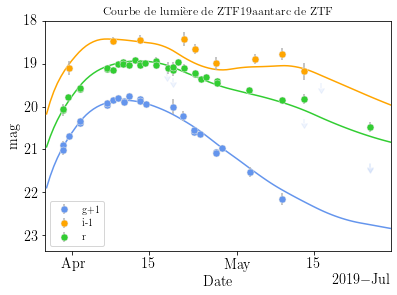

In [23]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
lc.show(ax, inmag=True, phase_range=[tmin, tmax], formattime=True, zeroline=False)

ax.set_xticks(ax.get_xticks())
ax.set_xlabel(r'Date')
ax.set_ylabel('mag')

ax.set_xlim(17982, 18045)
ax.set_ylim(top=18)

ax.legend(loc='lower left')
ax.set_title(f'Courbe de lumière de {cid} de {survey}')

print(r'z =', z)
fig.savefig(f'../../../Images/pdf/lc_{cid}.pdf', bbox_inches='tight')
fig.savefig(f'../../../Images/png/lc_{cid}.png', dpi=600)

### Temp calculations

In [4]:
for survey in surveys:
    full = df_full.loc[df_full['survey'] == survey]
    kept = df_nc.loc[df_nc['survey'] == survey]
    print(f'size {survey} =', len(full))
    print(f'kept {survey} =', len(kept))
    print(f'rati {survey} =', round(len(kept)/len(full), 2))
    print(f'leng {survey}:', round(np.min(full['redshifts']), 2),
                        r'< z <',
          round(np.max(full['redshifts']), 2))
    print(f'mean {survey}:', round(np.mean(full['redshifts']), 3))
    print('')

size SNF = 114
kept SNF = 114
rati SNF = 1.0
leng SNF: 0.02 < z < 0.08
mean SNF: 0.054

size ZTF = 2246
kept ZTF = 638
rati ZTF = 0.28
leng ZTF: 0.0 < z < 0.19
mean ZTF: 0.071

size LOWZ = 172
kept LOWZ = 172
rati LOWZ = 1.0
leng LOWZ: 0.01 < z < 0.07
mean LOWZ: 0.03

size SDSS = 335
kept SDSS = 167
rati SDSS = 0.5
leng SDSS: 0.04 < z < 0.4
mean SDSS: 0.205

size PS1 = 279
kept PS1 = 160
rati PS1 = 0.57
leng PS1: 0.03 < z < 0.63
mean PS1: 0.288

size SNLS = 236
kept SNLS = 102
rati SNLS = 0.43
leng SNLS: 0.13 < z < 1.06
mean SNLS: 0.638

size HST = 26
kept HST = 26
rati HST = 1.0
leng HST: 0.73 < z < 2.26
mean HST: 1.278



In [27]:
len(df_full.loc[~df_full['survey'].isin(['ZTF', 'LOWZ'])])

990

In [8]:
df_c.loc[df_c['survey'] == 'ZTF']

,survey,stretchs,stretchs_err,colors,colors_err,hostmass,hostmass_err,redshifts,infor,py,lssfr,lssfr_err_d,lssfr_err_u
114,ZTF,-1.954567,0.251621,-0.098493,0.051371,<NA>,<NA>,0.041145,0.493410,0.0,0.0,0.0,0.0
115,ZTF,-0.992664,0.083858,0.081165,0.032437,<NA>,<NA>,0.015439,0.475928,0.0,0.0,0.0,0.0
116,ZTF,-2.644002,0.230880,0.228290,0.047441,<NA>,<NA>,0.026023,0.483174,0.0,0.0,0.0,0.0
117,ZTF,-1.751680,0.057085,0.184992,0.029585,<NA>,<NA>,0.037559,0.490995,0.0,0.0,0.0,0.0
118,ZTF,2.024761,0.641019,0.157102,0.055590,<NA>,<NA>,0.028790,0.485057,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,ZTF,0.339432,0.081203,0.210782,0.030027,<NA>,<NA>,0.037764,0.491133,0.0,0.0,0.0,0.0
503,ZTF,-0.907218,0.078024,0.019987,0.027916,<NA>,<NA>,0.043710,0.495132,0.0,0.0,0.0,0.0
504,ZTF,-0.759236,0.075043,0.240956,0.031156,<NA>,<NA>,0.024682,0.482260,0.0,0.0,0.0,0.0
505,ZTF,0.323592,0.089957,-0.062301,0.029666,<NA>,<NA>,0.024389,0.482060,0.0,0.0,0.0,0.0


### $\mu_{\rm bias}$ for SDSS

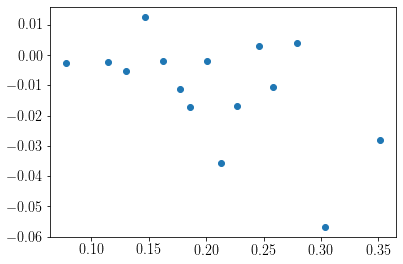

In [1105]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

d_SDSS = d.loc[d['IDSURVEY'].isin(find_id['SDSS'])].copy()
d_SDSS['zBIN'] = pd.qcut(d_SDSS.zCMB, 15)
d_SDSS = d_SDSS.groupby('zBIN').mean()
ax.scatter(d_SDSS.zCMB, d_SDSS.biasCor_mu)

### HD

In [1097]:
d.columns

Index(['CID', 'CIDint', 'IDSURVEY', 'TYPE', 'FIELD', 'CUTFLAG_SNANA', 'zCMB',
       'zCMBERR', 'zHD', 'zHDERR', 'VPEC', 'VPEC_ERR', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'SNRMAX1', 'SNRMAX2', 'SNRMAX3', 'PKMJD',
       'PKMJDERR', 'x1', 'x1ERR', 'c', 'cERR', 'mB', 'mBERR', 'x0', 'x0ERR',
       'COV_x1_c', 'COV_x1_x0', 'COV_c_x0', 'NDOF', 'FITCHI2', 'FITPROB', 'RA',
       'DECL', 'TGAPMAX', 'TrestMIN', 'TrestMAX', 'MWEBV', 'MU', 'MUMODEL',
       'MUERR', 'MUERR_RAW', 'MURES', 'MUPULL', 'ERRCODE', 'biasCor_mu',
       'biasCorErr_mu', 'biasCor_mB', 'biasCor_x1', 'biasCor_c',
       'biasScale_muCOV', 'IDSAMPLE'],
      dtype='object')

In [1099]:
df_nc.loc[df_nc['survey'] != 'LOWZ'].to_latex('/home/nicolas/Work/Articles/2022-PhD/figures/df_nc.tex')

In [1106]:
d.sort_values(by='zCMB')

,CID,CIDint,IDSURVEY,TYPE,FIELD,CUTFLAG_SNANA,zCMB,zCMBERR,zHD,zHDERR,...,MURES,MUPULL,ERRCODE,biasCor_mu,biasCorErr_mu,biasCor_mB,biasCor_x1,biasCor_c,biasScale_muCOV,IDSAMPLE
677,2009an,169,65,1,NaN,1,0.00931,0.0000,0.01043,0.0000,...,-0.010,-0.052,0,-0.023,0.004,-0.007,-0.007,0.005,0.962,0
583,2002cr,17,63,0,NaN,1,0.01025,0.0000,0.01012,0.0000,...,0.035,0.170,0,-0.013,0.005,-0.010,-0.005,0.001,0.958,0
702,2006bh,202,5,1,NaN,1,0.01042,0.0000,0.01082,0.0000,...,-0.000,-0.002,0,0.003,0.004,-0.024,-0.018,-0.010,0.955,0
585,2002dp,21,63,0,NaN,1,0.01045,0.0000,0.01038,0.0000,...,0.134,0.658,0,-0.025,0.008,-0.004,-0.006,0.007,0.964,0
688,2010Y,181,66,1,NaN,1,0.01123,0.0000,0.01226,0.0000,...,0.178,0.976,0,-0.009,0.008,-0.012,-0.060,-0.004,0.957,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025,Primo,6,106,-9,NaN,1,1.55000,0.0001,1.55000,0.0001,...,0.186,1.026,0,0.159,0.011,-0.067,-0.477,-0.099,0.707,4
1026,geta,7,106,-9,NaN,1,1.70000,0.0400,1.70000,0.0400,...,-0.008,-0.028,0,0.173,0.011,-0.042,0.284,-0.057,0.699,4
1027,stone,8,106,0,NaN,1,1.80000,0.0200,1.80000,0.0200,...,-0.048,-0.259,0,-0.169,0.011,-0.063,-0.345,0.018,0.632,4
1029,wilson,10,106,0,NaN,1,1.91400,0.0010,1.91400,0.0010,...,-0.238,-0.973,0,-0.440,0.027,-0.079,-0.934,0.072,0.525,4


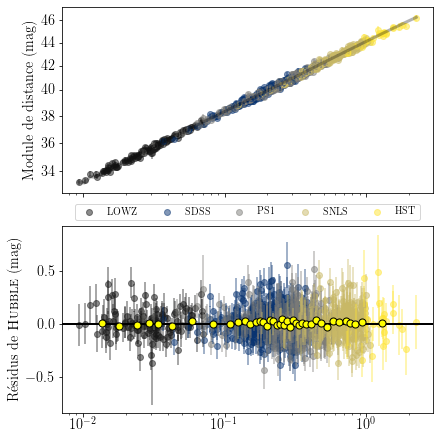

In [1119]:
fig = plt.figure(figsize=[6, 6], constrained_layout=True)
gs = fig.add_gridspec(2, 1)
axd = gs.subplots(sharex='col')
tcolors = colors.copy()
tcolors['LOWZ'] = tcolors['SNF']
for survey in surveys[1:]:
    d_used = d.loc[d['IDSURVEY'].isin(find_id[survey])]
    axd[0].scatter(d_used.zCMB, d_used.MU,
                color=tcolors[survey], alpha=.5, label=survey)
    axd[0].errorbar(d_used.zCMB, d_used.MU,
                    yerr=d_used.MUERR, ls='None',
                    color=tcolors[survey], alpha=.5)
    axd[1].scatter(d_used.zCMB, d_used.MURES,
                color=tcolors[survey], alpha=.5)
    axd[1].errorbar(d_used.zCMB, d_used.MURES,
                    yerr=d_used.MUERR, ls='None',
                    color=tcolors[survey], alpha=.5)

axd[0].plot(d.sort_values(by='zCMB').zCMB,
            d.sort_values(by='zCMB').MUMODEL,
            lw=3, color='k', alpha=.3)
    
d_cp = d.copy()
d_cp['zBIN'] = pd.qcut(d_cp['zCMB'], 40)
d_bin = d_cp.groupby('zBIN').mean()
axd[1].scatter(d_bin['zCMB'], d_bin['MURES'],
               c='yellow', edgecolors='k', s=50, zorder=3)

axd[1].axhline(0, lw=2, c='k')
axd[0].set_ylabel('Module de distance (mag)')
axd[1].set_ylabel(r'Résidus de \textsc{Hubble} (mag)')

for ax in axd:
    ax.set_xscale('log')
axd[0].set_yscale('log')
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
axd[0].yaxis.set_major_formatter(formatter)
axd[0].set_yticks(np.linspace(34, 46, 7))

axd[0].legend(ncol=5, loc='center', bbox_to_anchor=[0, -0.2, 1, 0.2])

fig.savefig('../../../Images/pdf/hd_panth.pdf', bbox_inches='tight')